# Introduction

This Jupyter Notebook contains the analysis University of Arizona researchers used to guide Tucson Electric Power's carbon goals as part of its 2020 IRP process.

We used a cumulative carbon budget framework that allows us to quantitatively relate the global carbon budget to TEP’s planning process. This framework uses the projected emissions from TEP and sets carbon budgets for different warming targets (1.5C, 2.0C, 2.5C) based on TEP's share of the U.S. electric utility sector, the electric utility sector’s share of the U.S. national emissions, and the U.S. national emissions share of global emissions. We also calculated the expected amount of warming for each portfolio if all other countries, sectors, and utilities were to scale their cumulative carbon emissions proportionally to TEP’s emissions. We analyzed the portfolios independent of their composition (% renewables, cost, coal retirement, etc.) and solely on the basis of whether they were expected to hit the different warming targets and the expected warming for each portfolio. 

Our approach addresses both quantity and timing of emissions reductions and sets a discrete budget for carbon emissions for TEP, the amount required to stay under the warming targets. Emissions reduction targets (e.g. 80% by 2005, etc.) that don’t account for timing of those reductions, could lead to higher emissions and more warming despite hitting the target. A key finding from our analysis is many different portfolios could reach a similar percent reduction in emissions based on the 2005 baseline, but that the cumulative emissions framework highlights the benefit of starting those reductions sooner. Essentially how you get to those percent reductions targets is just as important as the targets themselves.

Sections:

* [Carbon Budgets](#Carbon-Budgets)
  * [The Global Carbon Budget](#The-Global-Carbon-Budget)
  * [TEP Carbon Budget](#TEP-Carbon-Budget)
  * [Uncertainty](#Uncertainty)
* [Python Setup](#Python-Setup)
* [Define Constants](#Define-Constants)
* [TEP Historical Generation and Emissions](#TEP-Historical-Generation-and-Emissions)
  * [Generation](#Generation)
  * [Emissions](#Emissions)
  * [80% reduction of 2005 emissions by 2050](#80%-reduction-of-2005-emissions-by-2050)
* [Portfolios](#Portfolios)
  * [Global Budget](#Global-Budget)
  * [TEP Budget](#TEP-Budget)
  * [Cumulative Graphs](#Cumulative-Graphs)
  * [Yearly Graphs](#Yearly-Graphs)
  * [Global Warming Implications for each Portfolio](#Global-Warming-Implications-for-each-Portfolio)

# Carbon Budgets

## The Global Carbon Budget

Matthews et al 2009 demonstrated that the climate response to carbon emissions can be well-approximated by a simple relationship:

\begin{equation*}
CCR = \frac{\Delta T}{E_T}
\end{equation*}

where:

* $CCR$ is the carbon-climate response
* $\Delta T$ is the change in average global temperature
* $E_T$ is the cumulative carbon emissions

Matthews et al 2009 determined the $CCR$ to be 1.5 °C per Tt C by studying historical warming and emissions. Knowing the $CCR$ allows one to invert the equation to estimate future global warming based on only knowledge of carbon emissions or to estimate a carbon budget for a fixed temperature:

\begin{equation*}
\Delta T = E_T CCR
\end{equation*}

\begin{equation*}
E_T = \frac{\Delta T}{CCR}
\end{equation*}

Since then, this framework has been investigated by many other researchers and included in the IPCC 5th Assessment Report. Along the way, the literature stopped using the term "climate response to carbon emissions" ($CCR$) and started using "transient climate response to cumulative carbon emissions" ($TCRE$). They are the same thing.

Rogelj et al 2019 provide a comprehensive and understandable introduction to the $TCRE$ literature since Matthews et al 2009. Following Rogelj et al 2019, the global carbon budget $B_{lim}$ can be calculated as

\begin{equation*}
B_{lim} = \frac{T_{lim} - T_{hist} - T_{nonCO2} - T_{ZEC}}{TCRE} - E_{sfb}
\end{equation*}

where:

* $TCRE$ is the amount of warming for each unit of cumulative carbon emissions,
* $T_{lim}$ is the target level (e.g. 1.5 °C), 
* $T_{hist}$ is the amount of historical warming since the preindustrial period (~1.0 °C), 
* $T_{nonCO2}$ is the amount of warming from non-CO2 forcing (~0.0-0.2 °C), 
* $T_{ZEC}$ is the zero-emissions commitment (~0 °C), and
* $E_{sfb}$ is the additional Earth system feedback (0-100 Gt CO2). 

It is convenient to group the temperature terms into a remaining allowable temperature

\begin{equation*}
T_{rem} = T_{lim} - T_{hist} - T_{nonCO2} - T_{ZEC}
\end{equation*}

Then $B_{lim}$ becomes

\begin{equation*}
B_{lim} = \frac{T_{rem}}{TCRE} - E_{sfb}
\end{equation*}

## TEP Carbon Budget

Once the global carbon budget is known, the TEP carbon budget $B_{TEP}$ can be calculated as

\begin{equation*}
B_{TEP} = B_{lim} F_{US} F_{USElec} F_{TEP}
\end{equation*}

where:

* $F_{US}$ is the fraction of cumulative global emissions allocated to the United States, 
* $F_{USElec}$ is the fraction of the U.S. cumulative emissions allocated to the electricity sector, and 
* $F_{TEP}$ is the fraction of the U.S. electricity sector's cumulative emissions allocated to TEP. 

Determining $F_{US}$ is the job of international climate negotiations. We estimate $F_{US}=8.5\%$ based on ???.

We currently estimate $F_{USElec}=25\%$ based on ???. 

We estimate $F_{TEP}$ based on two methods: 1. the fraction of US electric emissions that TEP created in 2005 - 2018 (0.49%) and 2. the fraction of US electric generation that TEP created in 2005 - 2018 (0.28%). The emissions method gives historically large emitters a larger budget and historically small emitters a smaller budget. The generation method allocates budget to utilities regardless of their actual emissions, so utilities with low-emissions fleets will have excess budget and utilities with high-emissions fleet may struggle to meet the budget. We speculate that the emissions method may be more appropriate when each utility sets its own goals, while the generation method may be more appropriate under a coordinated system such as cap and trade.

More work is needed to understand how these estimates depend on the target $T_{lim}$. For example, a 1.5 °C target might imply a smaller $F_{USElec}$ because the electric sector can be decarbonized relatively easily, while a 2.5 °C target might allow a slower electric sector decarbonization and thus a larger $F_{USElec}$.

This analysis only considers TEP's direct, or scope 1, emissions. Emissions from purchased power are not included.

## Uncertainty

Rogelj 2019 assume that the uncertainty in $B_{lim}$ is dominated by uncertainty in $TCRE$ and apply the following formulation:

\begin{equation*}
B_{lim_{50}} = \frac{T_{rem}}{TCRE_{50}} - E_{sfb} \\
B_{lim_{66}} = \frac{T_{rem}}{TCRE_{33}} - E_{sfb} \\
B_{lim_{33}} = \frac{T_{rem}}{TCRE_{66}} - E_{sfb}
\end{equation*}

where 33, 50, and 66 represent the percentiles of $TCRE$ and $B_{lim}$.

If the uncertainty of other terms cannot be ignored, then we can use standard [propagation of uncertainty](https://en.wikipedia.org/wiki/Propagation_of_uncertainty) to derive the uncertainty of $B_{lim}$. First, the uncertainty in $T_{rem}$ is approximated by

\begin{equation*}
\sigma_{T_{rem}} = \sqrt{ \sigma_{T_{hist}}^2 + \sigma_{T_{nonCO2}}^2 + \sigma_{T_{ZEC}}^2 }
\end{equation*}

Then, the uncertainty in $B_{lim}$ is approximated by

\begin{equation*}
\sigma_{B_{lim}} = \sqrt{ \left(\frac{T_{rem}}{TCRE}\right)^2 \left(\left(\frac{\sigma_{T_{rem}}}{T_{rem}}\right)^2 + \left(\frac{\sigma_{TCRE}}{TCRE}\right)^2\right) + \sigma_{E_{sfb}}^2 }
\end{equation*}

The propagation of uncertainty described above is based on a first order Taylor series expansion of the function. The accuracy of the uncertainty estimate depends on the error of the first order Taylor series evaluated at the limit of the uncertainty. $B_{lim}$ is inversely proportional to $TCRE$, so the first order expansion could be a poor approximation when the $TCRE$ uncertainty is large. More study is needed to determine if $\sigma_{B_{lim}}$ is more accurately determined through only percentiles of $TCRE$ or through a full propagation of uncertainty for all terms. From a quick inspection, $\sigma_{T_{rem}} \approx 0.2$ C, so $(\sigma_{T_{rem}} / T_{rem})^2 \approx 0.16, 0.04$ (1.5 C or 2.0 C targets, respectively). Compare this to $(\sigma_{TCRE} / {TCRE})^2 \approx 0.05$. So uncertainty in $T_{rem}$ is not negligible compared to the uncertainty in $TCRE$ and Rogelj 2019's exclusive use of $TCRE$ uncertainty is questionable. As for $\sigma_{E_{sfb}}$, it is comparable to $E_{sfb}$, but this is only about 20% of the size of the $T_{rem}/TCRE$ term. The Taylor-series propgation of uncertainty approach always produces symmetrical error bars, whereas directly propagating only the $TCRE$ uncertainty following Rogelj 2019 leads to asymmetrical error bars. The most conservative approach may be to calculate the error bars using both approaches and take the largest.

The Taylor series expansion concerns are less relevant to the calculation of $B_{TEP}$ from $B_{lim}$ because $B_{TEP}$ is simply proportional to each term.

The uncertainty in $B_{TEP}$ is approximated by

\begin{equation*}
\sigma_{B_{TEP}} = B_{TEP} \sqrt{ \left( \frac{\sigma_{B_{lim}}}{B_{lim}} \right)^2 + \left( \frac{\sigma_{F_{US}}}{F_{US}} \right)^2 + \left( \frac{\sigma_{F_{USElec}}}{F_{USElec}} \right)^2 + \left( \frac{\sigma_{F_{TEP}}}{F_{TEP}} \right)^2 }
\end{equation*}

# Python Setup

In [1]:
%matplotlib inline

from collections import defaultdict
import os
from pathlib import Path

from cycler import cycler
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

plt.style.use('presentation')

mpl.rcParams['figure.figsize'] = (9, 6)

In [2]:
# document the packages we're using in this analysis
pd.show_versions()


INSTALLED VERSIONS
------------------
commit           : None
python           : 3.8.1.final.0
python-bits      : 64
OS               : Darwin
OS-release       : 19.5.0
machine          : x86_64
processor        : i386
byteorder        : little
LC_ALL           : None
LANG             : en_US.UTF-8
LOCALE           : en_US.UTF-8

pandas           : 1.0.1
numpy            : 1.18.1
pytz             : 2019.3
dateutil         : 2.8.1
pip              : 20.0.2
setuptools       : 45.2.0.post20200210
Cython           : None
pytest           : None
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : None
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 2.11.1
IPython          : 7.12.0
pandas_datareader: None
bs4              : None
bottleneck       : None
fastparquet      : None
gcsfs            : None
lxml.etree       : None
matplotlib       : 3.1.3
numexpr        

# Define Constants

In [3]:
c_to_co2 = 3.7  # 1 ton carbon = 3.7 tons CO2

# 1000 Pg = 1 Tt (t = metric ton)

# Matthews et al 2009 defined carbon climate response (CCR)
# but it's now more frequently referred to as 
# transient climate response to cumulative carbon emissions (TCRE)

# Mat2009 presented "best", 5%, and 95% confidence intervals
tcre_mat2009 = pd.Series(
    [1.5, 1.0, 2.1, 0.3], 
    index=['best', 'low', 'high', '1sigma']
)

tcre_tons_co2_mat2009 = tcre_mat2009 / 1e12 / c_to_co2  # degrees C per metric ton CO2
tcre_tons_co2_mat2009

best      4.054054e-13
low       2.702703e-13
high      5.675676e-13
1sigma    8.108108e-14
dtype: float64

In [4]:
# IPCC 2013 Chapter 12 pg 1108 summarizes a few estimates of CCR
# "Expert judgement based on the available evidence therefore 
#  suggests that the TCRE is *likely* between 0.8°C to 2.5°C per 
#  1000 PgC, for cumulative CO2 emissions less than about  
#  2000 PgC until the time at which temperature peaks."
# high and low are supposedly +/- 1 std dev

tcre_ipcc2013 = pd.Series(
    [1.65, 0.8, 2.5, 0.85],
    index=['best', 'low', 'high', '1sigma']
)

tcre_tons_co2_ipcc2013 = tcre_ipcc2013 / 1e12 / c_to_co2  # degrees C per metric ton CO2
tcre_tons_co2_ipcc2013

best      4.459459e-13
low       2.162162e-13
high      6.756757e-13
1sigma    2.297297e-13
dtype: float64

In [5]:
# From Rogelj (2019) as documented in the 2020 supplementary material revision 
# Nominally the same as IPCC 2013 but uncertainty is half as much and values
# a few % different

tcre_Tt_co2_rogelj2019 = pd.Series(
    [0.4503, 0.3483, 0.5524],
    index=['best', 'low', 'high']
)
tcre_Tt_co2_rogelj2019['1sigma'] = tcre_Tt_co2_rogelj2019['high'] - tcre_Tt_co2_rogelj2019['best']

tcre_tons_co2_rogelj2019 = tcre_Tt_co2_rogelj2019 / 1e12  # degrees C per metric ton CO2
tcre_tons_co2_rogelj2019

best      4.503000e-13
low       3.483000e-13
high      5.524000e-13
1sigma    1.021000e-13
dtype: float64

In [6]:
# TEP reports emissions in short tons, but TCRE is reported in metric tons
# 1 metric ton = 1.10231 short tons
metric_ton_to_short_ton = 1.10231  

In [7]:
# change this to the location of the data files on your computer
data_path = Path('data')

# change this if you want the notebook output (plots, csv) to go somewhere other than where this notebook lives
output_path = Path('output')

# TEP Historical Generation and Emissions

Load generation and emissions data.

In [8]:
tep_gen_emissions_path = data_path / 'Historic Generation and Emissions_Final no links.xlsx'
tep_generation_emissions = pd.read_excel(
    tep_gen_emissions_path,
    index_col=0,
    skiprows=4,
    nrows=8,
    usecols='C:R'
)

def process_raw_gen_emissions_df(df):
    df[2006] = np.nan  # 2006 data is missing, but file contains 0s instead of blank cells
    df = pd.concat([df.iloc[0:3], df.iloc[5:8]])  # remove mostly blank lines
    out = df.T.convert_dtypes()
    out = out.interpolate()
    return out.iloc[:, 0:3], out.iloc[:, 3:]

tep_generation, tep_emissions = process_raw_gen_emissions_df(tep_generation_emissions)

## Generation

In [9]:
tep_generation

,Total Energy Delivered,Market Purchases,TEP Generation
2005,1.285374e+07,1638737.000,1.121500e+07
2006,1.347929e+07,1842800.500,1.163649e+07
2007,1.410485e+07,2046864.000,1.205799e+07
2008,1.481311e+07,3358577.000,1.145453e+07
2009,1.406939e+07,3572993.000,1.049640e+07
2010,1.341278e+07,2700709.000,1.071207e+07
2011,1.360960e+07,2556751.065,1.105285e+07
2012,1.343640e+07,2184176.867,1.125222e+07
2013,1.353066e+07,2032840.647,1.149781e+07
2014,1.364063e+07,2893612.981,1.074702e+07


Text(0, 0.5, 'TEP Generation (MWh)')

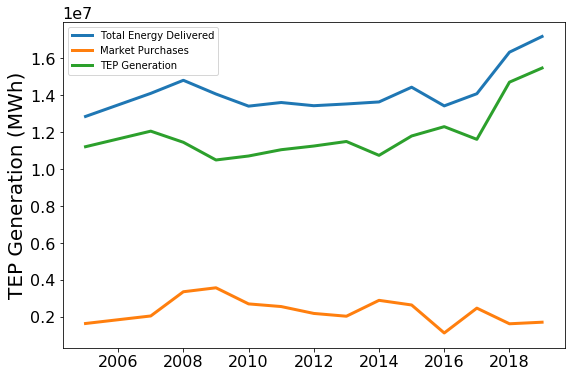

In [10]:
ax = tep_generation.plot()
ax.set_ylabel('TEP Generation (MWh)')

Load US generation for comparison

In [11]:
# https://www.eia.gov/energyexplained/electricity/electricity-in-the-us-generation-capacity-and-sales.php
us_generation_path = data_path / 'generation-major-source.csv'
us_generation = pd.read_csv(
    us_generation_path,
    skiprows=5,
    index_col=0
)
us_generation *= 1e6  # convert from billion kWh (1e9 * 1e3 = 1e12 = 1 TWh) to MWh (1e6)a
us_generation['total'] = us_generation.sum(axis=1)
us_generation

,coal,natural gas,nuclear,renewables,petroleum and other,total
1950,1.550000e+08,4.500000e+07,0.0,101000000.0,34000000.0,3.350000e+08
1951,1.850000e+08,5.700000e+07,0.0,105000000.0,29000000.0,3.760000e+08
1952,1.950000e+08,6.800000e+07,0.0,110000000.0,30000000.0,4.030000e+08
1953,2.190000e+08,8.000000e+07,0.0,110000000.0,38000000.0,4.470000e+08
1954,2.390000e+08,9.400000e+07,0.0,112000000.0,32000000.0,4.770000e+08
...,...,...,...,...,...,...
2015,1.352000e+09,1.333000e+09,797000000.0,544000000.0,50000000.0,4.076000e+09
2016,1.239000e+09,1.378000e+09,806000000.0,609000000.0,44000000.0,4.076000e+09
2017,1.206000e+09,1.296000e+09,805000000.0,687000000.0,40000000.0,4.034000e+09
2018,1.146000e+09,1.468000e+09,807000000.0,713000000.0,44000000.0,4.178000e+09


Text(0, 0.5, 'US Generation (MWh)')

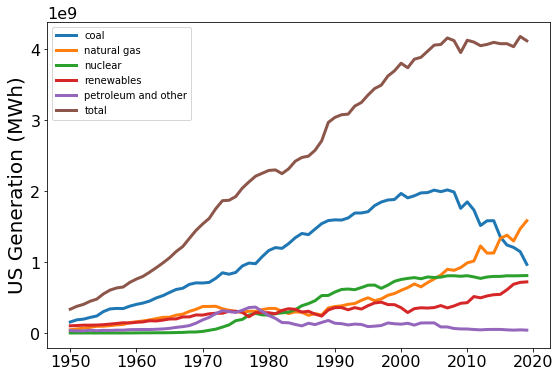

In [12]:
ax = us_generation.plot()
ax.set_ylabel('US Generation (MWh)')

Calculate TEP fraction of US generation. Use non-market generation only.

In [13]:
tep_generation_fraction = tep_generation['TEP Generation'] / us_generation['total']

In [14]:
tep_generation_fraction_mean = tep_generation_fraction.mean()
tep_generation_fraction_mean

0.0029042222385356497

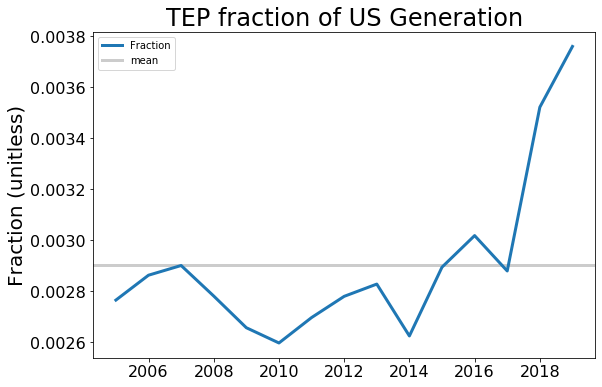

In [15]:
ax = tep_generation_fraction.dropna().plot(label='Fraction')
ax.set_ylabel('Fraction (unitless)')
ax.set_title('TEP fraction of US Generation')
ax.axhline(tep_generation_fraction_mean, color='k', alpha=0.2, zorder=-1, label='mean')
ax.legend()

## Emissions

In [16]:
tep_emissions

,Total Emissions,Market (Scope 3) Emissions,TEP Direct (Scope 1) Emissions
2005,1.300112e+07,8.465060e+05,1.215462e+07
2006,1.309707e+07,9.423684e+05,1.215470e+07
2007,1.319302e+07,1.038231e+06,1.215479e+07
2008,1.346173e+07,1.703571e+06,1.175816e+07
2009,1.264859e+07,1.845665e+06,1.080293e+07
2010,1.205482e+07,1.342536e+06,1.071228e+07
2011,1.247021e+07,1.217947e+06,1.125226e+07
2012,1.231243e+07,1.040465e+06,1.127196e+07
2013,1.242152e+07,9.677948e+05,1.145373e+07
2014,1.184934e+07,1.377591e+06,1.047175e+07


Text(0, 0.5, 'TEP Emissions (short tons of CO2)')

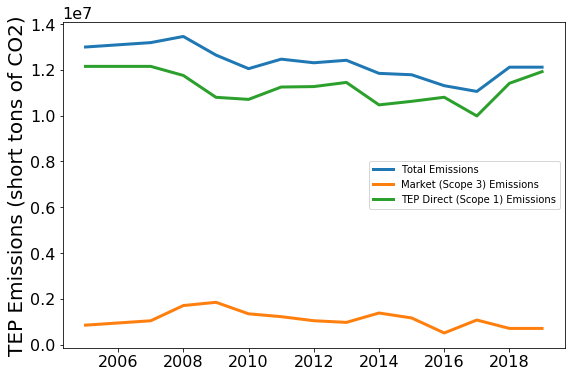

In [17]:
ax = tep_emissions.plot()
ax.set_ylabel('TEP Emissions (short tons of CO2)')

In [18]:
tep_cumulative_emissions = tep_emissions.cumsum()

Text(0, 0.5, 'Cumulative TEP Emissions (short tons CO2)')

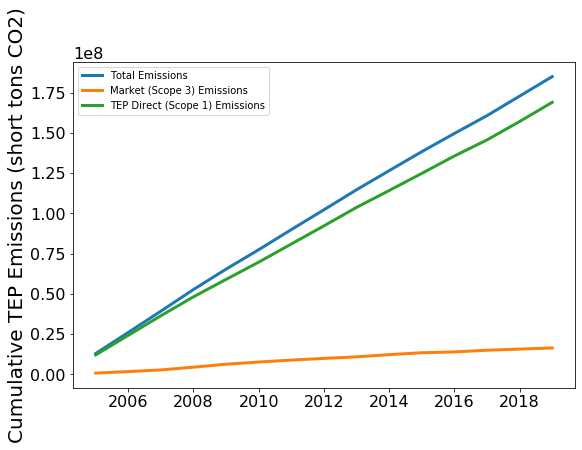

In [19]:
ax = tep_cumulative_emissions.plot()
ax.set_ylabel('Cumulative TEP Emissions (short tons CO2)')

best    0.000069
low     0.000053
high    0.000085
Name: 2019, dtype: float64


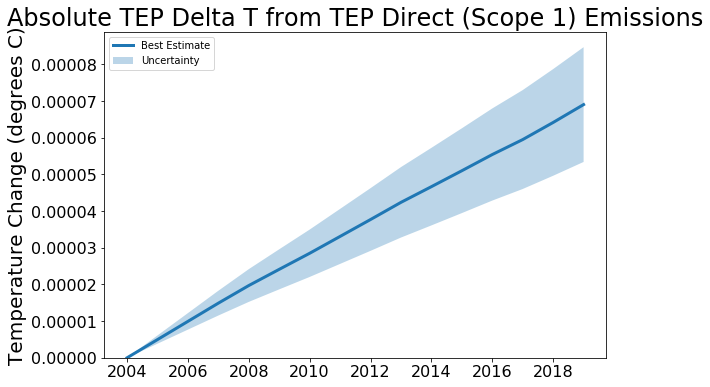

In [20]:
emission_type = 'TEP Direct (Scope 1) Emissions'  # can be any column in tep_cumulative_emissions
tep_degrees_c = {k: tcre * tep_cumulative_emissions[emission_type] / metric_ton_to_short_ton for k, tcre in tcre_tons_co2_rogelj2019[['best', 'low', 'high']].iteritems()}
tep_degrees_c = pd.DataFrame(tep_degrees_c)
# add points so that plot starts at 0
_zero_year = pd.DataFrame([[0, 0, 0]], columns=tep_degrees_c.columns, index=[2004])
tep_degrees_c = pd.concat([_zero_year, tep_degrees_c], axis=0)
print(tep_degrees_c.iloc[-1])

ax = tep_degrees_c['best'].plot(label='Best Estimate')
ax.fill_between(tep_degrees_c.index, tep_degrees_c['low'], tep_degrees_c['high'], alpha=0.3, label=f'Uncertainty')
ax.set_ylim(0, None)
ax.set_ylabel(f'Temperature Change (degrees C)')
ax.set_title(f'Absolute TEP Delta T from {emission_type}')
ax.legend(loc=2)

The plot shows TEP's contribution to global warming from emissions in 2005 through 2018. Over this period, TEP caused $64 \pm 15 \mu$°C of global temperature change.

Load US electric emissions data for comparison with TEP.

In [21]:
# https://www.eia.gov/totalenergy/data/monthly/index.php#environment
# MSN = mnemonic series names. Description = decoded MSN
# Values in units of million metric tons

us_elec_emissions_path = data_path / 'MER_T11_06.csv'
us_elec_emissions = pd.read_csv(
    us_elec_emissions_path,
    skiprows=0,
    dtype={'YYYYMM': str, 'Value': float, 'MSN': 'category', 'Description': 'category', 'Unit': 'category'},
    na_values='Not Available'
)

# split the YYYYMM column into Year and Month
us_elec_emissions['Year'] = us_elec_emissions['YYYYMM'].str[0:4].astype(int)
us_elec_emissions['Month'] = us_elec_emissions['YYYYMM'].str[4:6].astype(int)

# EIA encodes yearly totals as Month == 13. 
# We only need yearly so separate into different DataFrames
us_elec_emissions_monthly = us_elec_emissions[us_elec_emissions['Month'] != 13]
_dt_index = pd.to_datetime({'year': us_elec_emissions_monthly['Year'], 'month': us_elec_emissions_monthly['Month'], 'day': 1})
us_elec_emissions_monthly = us_elec_emissions_monthly.set_index(_dt_index)
us_elec_emissions_yearly = us_elec_emissions[us_elec_emissions['Month'] == 13]
_dt_index = pd.to_datetime({'year': us_elec_emissions_yearly['Year'], 'month': 1, 'day': 1})
us_elec_emissions_yearly = us_elec_emissions_yearly.set_index(us_elec_emissions_yearly['Year'])

# convert from "tidy" data to column data
us_elec_emissions_monthly = us_elec_emissions_monthly[['Value', 'Description']].pivot(columns='Description')['Value']
us_elec_emissions_yearly = us_elec_emissions_yearly[['Value', 'Description']].pivot(columns='Description')['Value']

In [22]:
us_elec_emissions_monthly

Description,Coal Electric Power Sector CO2 Emissions,"Distillate Fuel, Including Kerosene-Type Jet Fuel, Oil Electric Power Sector CO2 Emissions",Geothermal Energy Electric Power Sector CO2 Emissions,Natural Gas Electric Power Sector CO2 Emissions,Non-Biomass Waste Electric Power Sector CO2 Emissions,Petroleum Coke Electric Power Sector CO2 Emissions,Petroleum Electric Power Sector CO2 Emissions,Residual Fuel Oil Electric Power Sector CO2 Emissions,Total Energy Electric Power Sector CO2 Emissions
1973-01-01,72.076,2.375,NaN,12.175,NaN,0.128,27.369,24.867,111.621
1973-02-01,64.442,2.061,NaN,11.708,NaN,0.106,23.034,20.867,99.185
1973-03-01,64.084,1.171,NaN,13.994,NaN,0.083,21.034,19.780,99.112
1973-04-01,60.842,1.022,NaN,14.627,NaN,0.130,17.714,16.562,93.183
1973-05-01,61.798,0.949,NaN,17.344,NaN,0.167,18.870,17.754,98.012
...,...,...,...,...,...,...,...,...,...
2019-08-01,95.007,0.310,0.036,70.453,0.907,0.792,1.582,0.480,167.985
2019-09-01,85.750,0.282,0.034,59.876,0.878,0.736,1.420,0.402,147.959
2019-10-01,67.748,0.296,0.036,52.494,0.907,0.206,0.900,0.399,122.085
2019-11-01,75.814,0.311,0.034,44.821,0.878,0.368,1.037,0.358,122.584


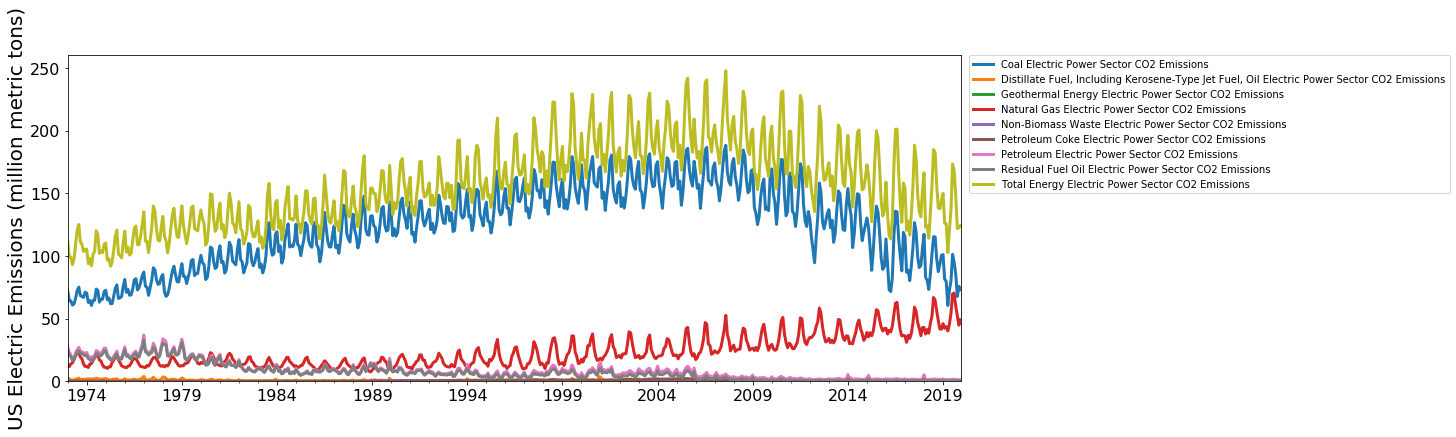

In [23]:
ax = us_elec_emissions_monthly.plot(figsize=(16, 6))
ax.set_ylabel('US Electric Emissions (million metric tons)')
ax.set_ylim(0, None)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

In [24]:
us_elec_emissions_yearly

Description,Coal Electric Power Sector CO2 Emissions,"Distillate Fuel, Including Kerosene-Type Jet Fuel, Oil Electric Power Sector CO2 Emissions",Geothermal Energy Electric Power Sector CO2 Emissions,Natural Gas Electric Power Sector CO2 Emissions,Non-Biomass Waste Electric Power Sector CO2 Emissions,Petroleum Coke Electric Power Sector CO2 Emissions,Petroleum Electric Power Sector CO2 Emissions,Residual Fuel Oil Electric Power Sector CO2 Emissions,Total Energy Electric Power Sector CO2 Emissions
Year,,,,,,,,,
1973,811.791,19.914,NaN,198.857,NaN,1.559,275.704,254.231,1286.352
1974,800.131,22.525,NaN,186.716,NaN,1.922,263.796,239.348,1250.643
1975,823.740,16.509,NaN,171.891,NaN,0.216,248.184,231.459,1243.815
1976,911.346,17.738,NaN,167.220,NaN,0.209,272.618,254.671,1351.184
1977,962.143,20.671,NaN,174.225,NaN,0.300,305.758,284.787,1442.126
1978,959.916,20.151,NaN,174.915,NaN,1.225,312.825,291.450,1447.657
1979,1055.704,13.009,NaN,191.677,NaN,0.824,257.867,244.034,1505.248
1980,1136.594,12.337,NaN,200.454,NaN,0.551,206.668,193.780,1543.716
1981,1180.367,9.066,NaN,197.925,NaN,0.427,172.873,163.380,1551.165


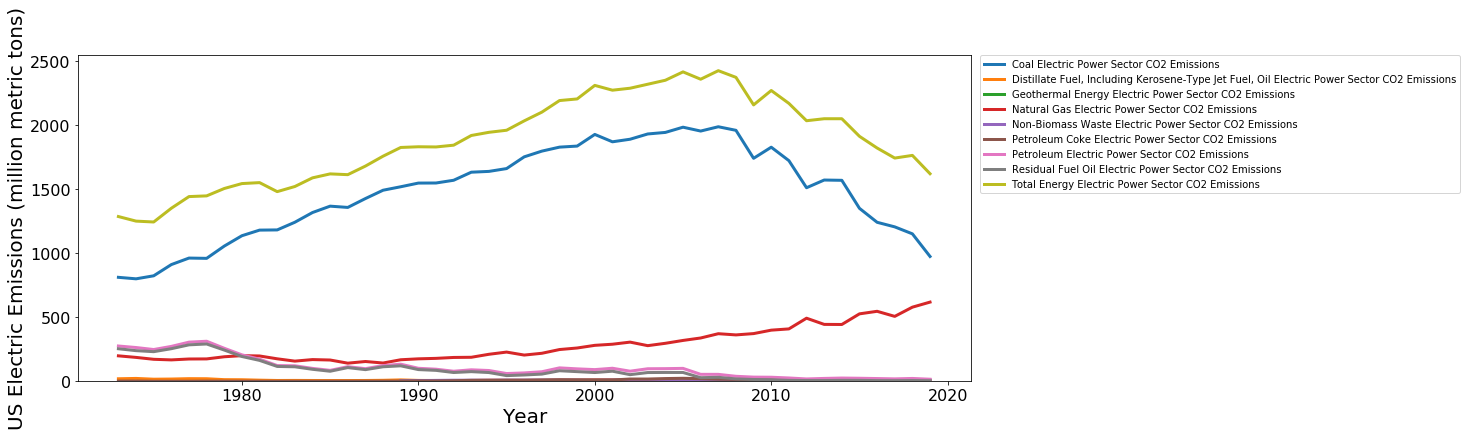

In [25]:
ax = us_elec_emissions_yearly.plot(figsize=(16, 6))
ax.set_ylabel('US Electric Emissions (million metric tons)')
ax.set_ylim(0, None)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

best    0.039749
low     0.030745
high    0.048761
Name: 2019, dtype: float64


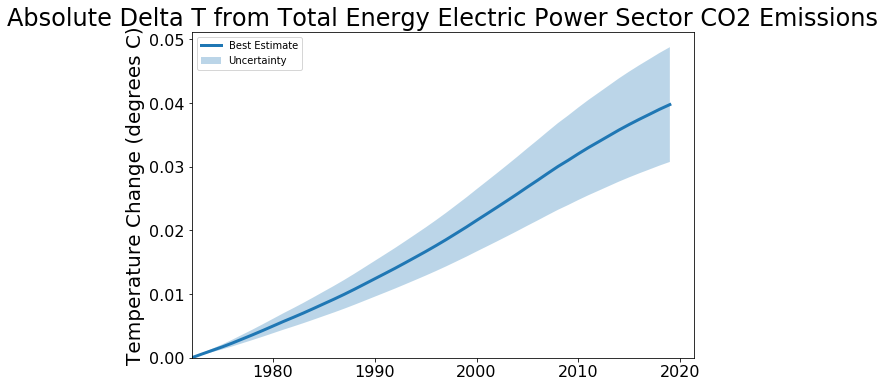

In [26]:
emission_type = 'Total Energy Electric Power Sector CO2 Emissions'  
cumulative_emissions = us_elec_emissions_yearly[emission_type].cumsum() * 1e6
us_electric_degrees_c = {k: tcre * cumulative_emissions for k, tcre in tcre_tons_co2_rogelj2019[['best', 'low', 'high']].iteritems()}
us_electric_degrees_c = pd.DataFrame(us_electric_degrees_c)
# add points so that plot starts at 0
_zero_year = pd.DataFrame([[0, 0, 0]], columns=us_electric_degrees_c.columns, index=[us_electric_degrees_c.index[0] - 1])
us_electric_degrees_c = pd.concat([_zero_year, us_electric_degrees_c], axis=0)
print(us_electric_degrees_c.iloc[-1])

ax = us_electric_degrees_c['best'].plot(label='Best Estimate')
ax.fill_between(us_electric_degrees_c.index, us_electric_degrees_c['low'], us_electric_degrees_c['high'], alpha=0.3, label=f'Uncertainty')
ax.set_xlim(us_electric_degrees_c.index[0], None)
ax.set_ylim(0, None)
ax.set_ylabel(f'Temperature Change (degrees C)')
ax.set_title(f'Absolute Delta T from {emission_type}')
ax.legend(loc=2)

In [27]:
us_elec_emissions_yearly_total = us_elec_emissions_yearly['Total Energy Electric Power Sector CO2 Emissions']

In [28]:
tep_emissions_fraction = tep_emissions['TEP Direct (Scope 1) Emissions'] / (us_elec_emissions_yearly_total * 1e6 * metric_ton_to_short_ton)
tep_emissions_fraction = tep_emissions_fraction.dropna()
tep_emissions_fraction

2005    0.004565
2006    0.004676
2007    0.004547
2008    0.004495
2009    0.004542
2010    0.004280
2011    0.004705
2012    0.005027
2013    0.005069
2014    0.004634
2015    0.005041
2016    0.005382
2017    0.005199
2018    0.005872
2019    0.006676
dtype: float64

In [29]:
tep_emissions_fraction_mean = tep_emissions_fraction.mean()
tep_emissions_fraction_mean

0.004980624412919814

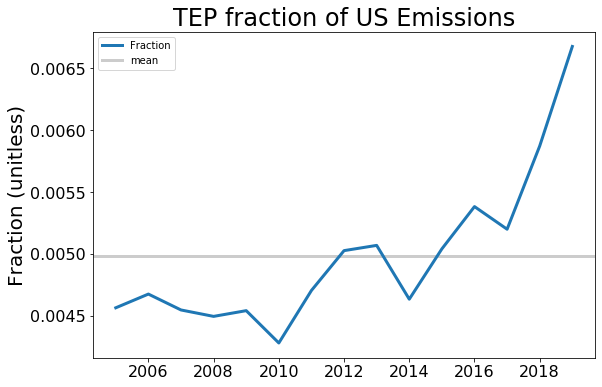

In [30]:
ax = tep_emissions_fraction.dropna().plot(label='Fraction')
ax.set_ylabel('Fraction (unitless)')
ax.set_title('TEP fraction of US Emissions')
ax.axhline(tep_emissions_fraction_mean, color='k', alpha=0.2, zorder=-1, label='mean')
ax.legend()

In [31]:
tep_emissions_percent = tep_emissions_fraction * 100
tep_generation_percent = tep_generation_fraction * 100
tep_emissions_percent_mean = tep_emissions_fraction_mean * 100
tep_generation_percent_mean = tep_generation_fraction_mean * 100

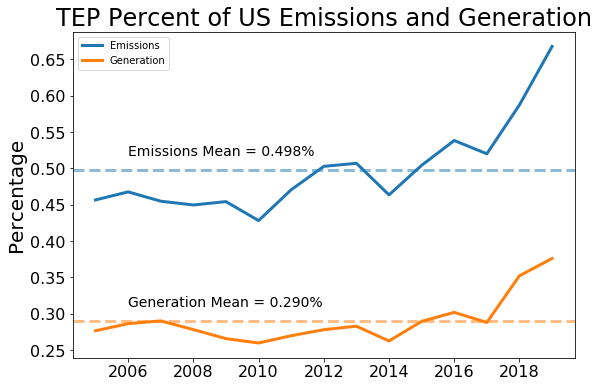

In [32]:
fig, ax = plt.subplots()
tep_emissions_percent.dropna().plot(ax=ax, label='Emissions')
tep_generation_percent.dropna().plot(ax=ax, label='Generation')
ax.axhline(tep_emissions_percent_mean, color='C0', alpha=0.5, zorder=-1, linestyle='--')
ax.axhline(tep_generation_percent_mean, color='C1', alpha=0.5, zorder=-1, linestyle='--')
fontdict = dict(size=14)
ax.text(2006, tep_emissions_percent_mean + 0.02, f'Emissions Mean = {tep_emissions_percent_mean:0.3f}%', fontdict)
ax.text(2006, tep_generation_percent_mean + 0.02, f'Generation Mean = {tep_generation_percent_mean:0.3f}%', fontdict)
ax.set_ylabel('Percentage')
ax.set_title('TEP Percent of US Emissions and Generation')
ax.legend()

fig.savefig(output_path / f'historical_tep_emissions_generation_percent.png', dpi=300)

## Percent reduction of 2005 emissions by 2050

Construct a cumulative emissions scenario based on the frequently adopted "80%, 90%, or 100% by 2050" metrics. We assume a linear reduction from 2020 to 2050, but the end goal reduction is with respect to 2005.

In [33]:
tep_emissions['TEP Direct (Scope 1) Emissions']

2005    1.215462e+07
2006    1.215470e+07
2007    1.215479e+07
2008    1.175816e+07
2009    1.080293e+07
2010    1.071228e+07
2011    1.125226e+07
2012    1.127196e+07
2013    1.145373e+07
2014    1.047175e+07
2015    1.062712e+07
2016    1.080559e+07
2017    9.989010e+06
2018    1.141586e+07
2019    1.192496e+07
Name: TEP Direct (Scope 1) Emissions, dtype: float64

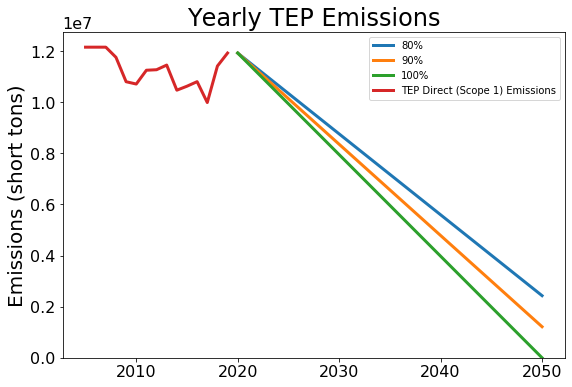

In [34]:
last_year = 2019
tep_emissions_2005 = tep_emissions.loc[2005, 'TEP Direct (Scope 1) Emissions']
start_emissions_by2050 = tep_emissions.loc[last_year, 'TEP Direct (Scope 1) Emissions']
end_emissions_by2050 = pd.Series({'80%': 0.2, '90%': 0.1, '100%': 0.0}) * tep_emissions_2005
start_year_by2050 = 2020
end_year_by2050 = 2050
full_index_by2050 = np.arange(start_year_by2050, end_year_by2050 + 1)
yearly_emissions_by2050 = pd.DataFrame(index=full_index_by2050, columns=end_emissions_by2050.index, dtype=float)
yearly_emissions_by2050.iloc[0] = start_emissions_by2050
yearly_emissions_by2050.iloc[-1] = end_emissions_by2050
yearly_emissions_by2050 = yearly_emissions_by2050.interpolate(how='time')

ax = yearly_emissions_by2050.plot()
tep_emissions['TEP Direct (Scope 1) Emissions'].plot(ax=ax)
ax.set_ylim(0, None)
ax.set_ylabel('Emissions (short tons)')
ax.legend()

ax.set_title(f'Yearly TEP Emissions')

ax.get_figure().savefig(output_path / 'historical_and_projected_percent_by2050.png', dpi=300)

In [35]:
yearly_emissions_by2050_cumulative = yearly_emissions_by2050.cumsum()
yearly_emissions_by2050_cumulative

,80%,90%,100%
2020,1.192496e+07,1.192496e+07,1.192496e+07
2021,2.353344e+07,2.349293e+07,2.345241e+07
2022,3.482546e+07,3.470392e+07,3.458237e+07
2023,4.580102e+07,4.555793e+07,4.531483e+07
2024,5.646010e+07,5.605495e+07,5.564979e+07
2025,6.680272e+07,6.619499e+07,6.558726e+07
2026,7.682887e+07,7.597805e+07,7.512722e+07
2027,8.653855e+07,8.540412e+07,8.426969e+07
2028,9.593176e+07,9.447321e+07,9.301466e+07
2029,1.050085e+08,1.031853e+08,1.013621e+08


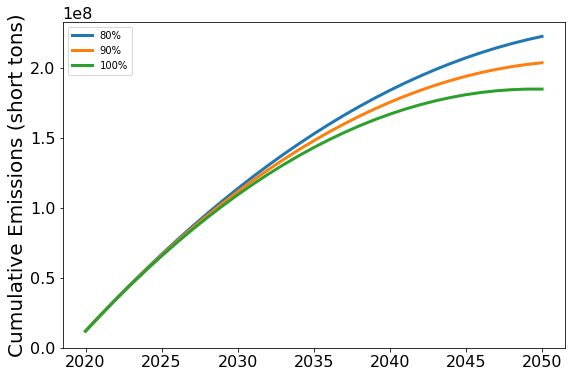

In [36]:
ax = yearly_emissions_by2050_cumulative.plot()
ax.set_ylim(0, None)
ax.set_ylabel('Cumulative Emissions (short tons)')
ax.legend()

# Portfolios

In [37]:
def read_portfolio(path):
    """Read a xlsx TEP portfolio.
    
    Parameters
    ----------
    path : pathlib.Path
    
    Returns
    -------
    name : str
        Portfolio name
    changes : pd.DataFrame
        Summary of year to year changes (MW)
    energy : pd.DataFrame
        Yearly energy data (GWh)
    financial : pd.DataFrame
        Yearly financial data (thousands of $)
    environmental : pd.DataFrame
        Yearly environmental data ()
    """
    name = path.name.split('-')[1].split('.')[0].lstrip(' ')
    
    usecols = 'D:AI'
    
    # units of MW changes
    changes = pd.read_excel(
        path,
        skiprows=5,
        nrows=4,
        index_col=0,
        usecols=usecols
    ).T

    # units of GWh
    energy = pd.read_excel(
        path,
        skiprows=13,
        nrows=18,
        index_col=0,
        usecols=usecols
    ).dropna().T

    # units of thousands of $
    financial = pd.read_excel(
        path,
        skiprows=35,
        nrows=2,
        index_col=0,
        usecols=usecols
    ).T

    # units of short tons CO2, short tons NOx, thousand gallons water
    environmental = pd.read_excel(
        path,
        skiprows=41,
        nrows=7,
        index_col=0,
        usecols=usecols
    ).dropna().T
    
    return name, changes, energy, financial, environmental

In [38]:
portfolio = 'P01aL1M1E1'
path = data_path / f'Portfolio Summary - {portfolio}.xlsx'
name, changes, energy, financial, environmental = read_portfolio(path)

Text(0, 0.5, 'CO2 Emissions (Short Tons)')

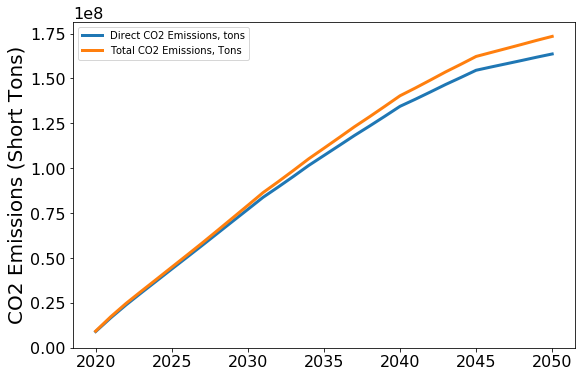

In [39]:
fig, ax = plt.subplots()
environmental.cumsum()[['Direct CO2 Emissions, tons', 'Total CO2 Emissions, Tons']].plot(ax=ax)
ax.set_ylim(0, None)
ax.set_ylabel('CO2 Emissions (Short Tons)')

## Global Budget

In [40]:
HISTORICAL_WARMING = 0.97
NON_CO2_TEMPERATURE_EFFECT = (0.1366, 0.2221)
ZERO_EMISSIONS_COMMITMENT_EFFECT = 0.
EARTH_SYSTEM_FEEDBACK = 100e9
EMISSIONS_SINCE_HISTORICAL = 289.8e9

In [41]:
def calc_carbon_budget_globe(
        target, 
        transient_climate_response,
        historical_warming=HISTORICAL_WARMING, 
        non_CO2_temperature_effect=None,
        zero_emissions_commitment_effect=ZERO_EMISSIONS_COMMITMENT_EFFECT,
        earth_system_feedback=EARTH_SYSTEM_FEEDBACK,
        emissions_since_historical=EMISSIONS_SINCE_HISTORICAL,
    ):
    """Calculate global carbon budget for global temperature change
    above preindustrial period. Uncertainty is not explicitly 
    accounted for, but may be empirically determined by supplying 
    array or Series inputs for the parameters.
    
    Parameters
    ----------
    target : float
        Global temperature change target.
    transient_climate_response : float
        The global mean amount of warming for each unit of 
        cumulative carbon emissions. 
    historical_warming : float
        Degrees change over a preindustrial period. 
    non_CO2_temperature_effect : None or tuple of float
        Account for warming due to non-CO2 forcing such as
        sulfur dioxide. 2nd element is the uncertainty.
        If None, set based on target.
    zero_emissions_commitment_effect : float
        Account for nonlinearity or time lag of TCRE
    earth_system_feedback : float
        Account for feedback from changes such as melting 
        of permafrost.
    emissions_since_historical : float
        Additional emissions since the period defined by
        historical_warming.
    
    Returns
    -------
    budget : array_like
    
    Notes
    -----
    Default values from Rogelj et al (2019) and 
    Rogelj et al (2020) correction
    """
    
    # account for warming due to non-CO2 forcing
    # e.g. changes in sulfur dioxide associated with changing fuel mixes
    if non_CO2_temperature_effect is None:
        if target < 2.0:
            non_CO2_temperature_effect = 0.1366  # degrees C (0 - 0.2 C 90% range) if target = 1.5 C
        else:
            non_CO2_temperature_effect = 0.2221  # degrees C (0.1 - 0.4 C 90% range) if target = 2 C
    
    remaining_warming = (
        target 
        - historical_warming 
        - non_CO2_temperature_effect 
        - zero_emissions_commitment_effect
    )

    # print('remaining warming:', remaining_warming)
    
    budget_remaining = remaining_warming / transient_climate_response

    # print('budget remaining:', budget_remaining)

    carbon_budget_globe = budget_remaining - earth_system_feedback - emissions_since_historical

    # print('budget:', carbon_budget_globe)

    return carbon_budget_globe

In [42]:
calc_carbon_budget_globe(1.5, tcre_tons_co2_rogelj2019.loc[['best', 'low', 'high']]) / 1e9

best    483.839796
low     739.686075
high    322.365098
dtype: float64

In [43]:
calc_carbon_budget_globe(2.0, tcre_tons_co2_rogelj2019.loc[['best', 'low', 'high']]) / 1e9

best    1404.337242
low     1929.752110
high    1072.727154
dtype: float64

In [44]:
def calc_carbon_budget_globe_unc(
        target, 
        transient_climate_response,
        transient_climate_response_unc,
        historical_warming=0.97, 
        historical_warming_unc=0,
        non_CO2_temperature_effect=None,
        zero_emissions_commitment_effect=0,
        zero_emissions_commitment_effect_unc=0,
        earth_system_feedback=100e9,
        earth_system_feedback_unc=100e9,
        emissions_since_historical=289.8e9,
        emissions_since_historical_unc=0
    ):
    """Calculate global carbon budget for global temperature change
    above preindustrial period. Use propagation of error to determine
    uncertainty of the budget.
    
    Parameters
    ----------
    target : float
        Global temperature change target.
    transient_climate_response : float
        The global mean amount of warming for each unit of 
        cumulative carbon emissions. 
    transient_climate_response_unc : float
        TCRE uncertainty. Same units as TCRE.
    historical_warming : float
        Degrees change over a preindustrial period. 
    historical_warming_unc : float
    non_CO2_temperature_effect : None or tuple of float
        Account for warming due to non-CO2 forcing such as
        sulfur dioxide. 2nd element is the uncertainty.
        If None, set based on target.
    zero_emissions_commitment_effect : float
        Account for nonlinearity or time lag of TCRE
    zero_emissions_commitment_effect_unc : float
    earth_system_feedback : float
        Account for feedback from changes such as melting 
        of permafrost.
    earth_system_feedback_unc : float
    emissions_since_historical : float
        Additional emissions since the period defined by
        historical_warming.
    emissions_since_historical_unc : float
    
    Returns
    -------
    budget : pd.Series
        Values for best, low, high, and +/- 1 sigma
    
    Notes
    -----
    Default values from Rogelj et al (2019) and 
    Rogelj et al (2020) correction
    """
    
    # account for warming due to non-CO2 forcing
    # e.g. changes in sulfur dioxide associated with changing fuel mixes
    if non_CO2_temperature_effect is None:
        if target < 2.0:
            non_CO2_temperature_effect = 0.1366  # degrees C (0 - 0.2 C 90% range) if target = 1.5 C
            non_CO2_temperature_effect_unc = 0.050  # guessing at 1 sigma
        else:
            non_CO2_temperature_effect = 0.2221  # degrees C (0.1 - 0.4 C 90% range) if target = 2 C
            non_CO2_temperature_effect_unc = 0.075  # guessing at 1 sigma
        # non_CO2_temperature_effect_unc = 0  # according to Rogelj et al (2020) correction
    
    remaining_warming = (
        target 
        - historical_warming 
        - non_CO2_temperature_effect 
        - zero_emissions_commitment_effect
    )
    remaining_warming_unc = np.sqrt(
        historical_warming_unc ** 2 + 
        non_CO2_temperature_effect_unc ** 2 + 
        zero_emissions_commitment_effect_unc ** 2
    )
    # print('remaining warming:', remaining_warming, remaining_warming_unc)
    
    budget_remaining = remaining_warming / transient_climate_response
    budget_remaining_unc = budget_remaining * np.sqrt(
        (remaining_warming_unc / remaining_warming) ** 2 +
        (transient_climate_response_unc / transient_climate_response) ** 2
    )
    # print('budget remaining:', budget_remaining, budget_remaining_unc)

    carbon_budget_globe = budget_remaining - earth_system_feedback - emissions_since_historical
    carbon_budget_globe_unc = np.sqrt(
        budget_remaining_unc ** 2 + 
        earth_system_feedback_unc ** 2 + 
        emissions_since_historical_unc ** 2
    )
    # print('budget:', carbon_budget_globe, carbon_budget_globe_unc)

    carbon_budget_globe = pd.Series(
        [carbon_budget_globe, 
         carbon_budget_globe - carbon_budget_globe_unc, 
         carbon_budget_globe + carbon_budget_globe_unc, 
         carbon_budget_globe_unc],
        index=['best', 'low', 'high', '1sigma']
    )
    return carbon_budget_globe

In [45]:
calc_carbon_budget_globe_unc(
    1.5, tcre_tons_co2_rogelj2019['best'], tcre_tons_co2_rogelj2019['1sigma']) / 1e9

best      483.839796
low       235.711330
high      731.968261
1sigma    248.128466
dtype: float64

In [46]:
calc_carbon_budget_globe_unc(
    2.0, tcre_tons_co2_rogelj2019['best'], tcre_tons_co2_rogelj2019['1sigma']) / 1e9

best      1404.337242
low        953.531426
high      1855.143058
1sigma     450.805816
dtype: float64

In [47]:
# take global values directly from paper for comparison with values calculated above
carbon_budget_globe_15_rogelj2019 = pd.Series([480, 320, 740], index=['best', 'low', 'high']) * 1e9
carbon_budget_globe_20_rogelj2019 = pd.Series([1400, 1930, 1070], index=['best', 'low', 'high']) * 1e9

In [48]:
tep_emissions_fraction_mean  # 2005 - 2019

0.004980624412919814

In [49]:
def calc_carbon_budget_tep_unc(
        carbon_budget_globe, 
        carbon_budget_globe_unc,
        us_frac=0.07,  # assume budget based INDC estimates (PROVISIONAL)
        us_frac_unc=0,
        us_electric_frac=0.3,
        us_electric_frac_unc=0,
        tep_frac=0.0048595,  # avg fraction of emissions 2005 - 2018
        tep_frac_unc=0
    ):
    """
    Parameters
    ----------
    carbon_budget_globe : float
        Global carbon budget
    carbon_budget_globe_unc : float
    us_frac : float
        Fraction of cumulative global emissions allocated to US
    us_frac_unc : float
    us_electric_frac : float
        Fraction of cumulative US emissions allocated to US electric sector
    us_electric_frac_unc : float
    tep_frac : float
        Fraction of cumulative US electric emissions allocated to TEP
    tep_frac_unc : float
        Probably should be ~0 due to high correlation with other parameters
        
    Returns
    -------
    carbon_budget_tep : pd.Series
        Values for best, low, high, and +/- 1 sigma
        TEP carbon budget (same units as input global budget)
    """
    carbon_budget_tep = carbon_budget_globe * us_frac * us_electric_frac * tep_frac
    carbon_budget_tep_unc = carbon_budget_tep * np.sqrt(
        (carbon_budget_globe_unc / carbon_budget_globe) ** 2 +
        (us_frac_unc) ** 2 +
        (us_electric_frac_unc / us_electric_frac) ** 2 +
        (tep_frac_unc / tep_frac) ** 2
    )
    carbon_budget_tep = pd.Series(
        [carbon_budget_tep, 
         carbon_budget_tep - carbon_budget_tep_unc, 
         carbon_budget_tep + carbon_budget_tep_unc, 
         carbon_budget_tep_unc],
        index=['best', 'low', 'high', '1sigma']
    )
    return carbon_budget_tep

In [50]:
global_rogelj2019 = calc_carbon_budget_globe_unc(
    1.5, tcre_tons_co2_rogelj2019['best'], tcre_tons_co2_rogelj2019['1sigma'])
tep_rogelj2019 = calc_carbon_budget_tep_unc(global_rogelj2019['best'], global_rogelj2019['1sigma'])
tep_rogelj2019

best      4.937561e+07
low       2.405422e+07
high      7.469700e+07
1sigma    2.532139e+07
dtype: float64

In [51]:
global_rogelj2019 = calc_carbon_budget_globe_unc(
    1.5, tcre_tons_co2_rogelj2019['best'], tcre_tons_co2_rogelj2019['1sigma'])
tep_rogelj2019 = calc_carbon_budget_tep_unc(
    global_rogelj2019['best'], 
    global_rogelj2019['1sigma'],
    us_frac_unc=0.02,
    us_electric_frac_unc=0.1,
)
tep_rogelj2019

best      4.937561e+07
low       1.915920e+07
high      7.959202e+07
1sigma    3.021641e+07
dtype: float64

## TEP Budget

In [52]:
US_FRAC = 0.085
US_ELECTRIC_FRAC = 0.25
TEP_FRAC = 0.004980624412919814

In [53]:
def calc_carbon_budget_tep(
        carbon_budget_globe, 
        us_frac=US_FRAC,  # assume budget based INDC estimates (PROVISIONAL)
        us_electric_frac=US_ELECTRIC_FRAC,
        tep_frac=TEP_FRAC,  # avg fraction of emissions 2005 - 2019
    ):
    """Calculate TEP carbon budget based on global carbon budget. 
    Uncertainty is not explicitly accounted for, but may be 
    empirically determined by supplying array or Series inputs 
    for the parameters.
    
    Parameters
    ----------
    carbon_budget_globe : array_like
        Global carbon budget
    us_frac : float
        Fraction of cumulative global emissions allocated to US
    us_electric_frac : float
        Fraction of cumulative US emissions allocated to US electric sector
    tep_frac : float
        Fraction of cumulative US electric emissions allocated to TEP
        
    Returns
    -------
    carbon_budget_tep : array_like
        TEP carbon budget (same units as input global budget)
    """
    carbon_budget_tep = carbon_budget_globe * us_frac * us_electric_frac * tep_frac
    return carbon_budget_tep

In [54]:
global_rogelj2019 = calc_carbon_budget_globe(
    1.5, tcre_tons_co2_rogelj2019[['best', 'low', 'high']])
tep_rogelj2019 = calc_carbon_budget_tep(
    global_rogelj2019, 
)
tep_rogelj2019

best    5.120877e+07
low     7.828709e+07
high    3.411856e+07
dtype: float64

In [55]:
# TEP carbon budget if the only uncertainty is TCRE
carbon_budgets_tep_emissions_based = {
    k: calc_carbon_budget_tep(calc_carbon_budget_globe(k, tcre_tons_co2_rogelj2019[['best', 'low', 'high']]), tep_frac=tep_emissions_fraction_mean) 
       for k in (1.5, 2.0, 2.5)
}
carbon_budgets_tep_emissions_based = pd.DataFrame(carbon_budgets_tep_emissions_based)
carbon_budgets_tep_emissions_based *= metric_ton_to_short_ton
carbon_budgets_tep_emissions_based

,1.5,2.0,2.5
best,5.644794e+07,1.638392e+08,2.933824e+08
low,8.629665e+07,2.251376e+08,3.926176e+08
high,3.760923e+07,1.251514e+08,2.307511e+08


In [56]:
# TEP carbon budget if the only uncertainty is TCRE
carbon_budgets_tep_generation_based = {
    k: calc_carbon_budget_tep(calc_carbon_budget_globe(k, tcre_tons_co2_rogelj2019[['best', 'low', 'high']]), tep_frac=tep_generation_fraction_mean) 
       for k in (1.5, 2.0, 2.5)
}
carbon_budgets_tep_generation_based = pd.DataFrame(carbon_budgets_tep_generation_based)
carbon_budgets_tep_generation_based *= metric_ton_to_short_ton
carbon_budgets_tep_generation_based

,1.5,2.0,2.5
best,3.291502e+07,9.553532e+07,1.710725e+08
low,5.031992e+07,1.312786e+08,2.289369e+08
high,2.193010e+07,7.297629e+07,1.345519e+08


In [57]:
now = pd.Timestamp.utcnow().strftime('%Y-%m-%d %H:%M:%SZ')

comment = f'# TEP carbon budget in units of short tons. Created {now} \n'
with open(output_path / 'carbon_budgets_emissions_based.csv', 'w') as f:
    f.write(comment)
    carbon_budgets_tep_emissions_based.to_csv(f, index_label='estimate_emissions_based')
    
with open(output_path / 'carbon_budgets_generation_based.csv', 'w') as f:
    f.write(comment)
    carbon_budgets_tep_generation_based.to_csv(f, index_label='estimate_generation_based')

## Cumulative Graphs

In [58]:
scope = 'Direct CO2 Emissions, tons'

In [59]:
cumulative = environmental.cumsum()[scope]

In [60]:
portfolios = data_path.glob('Portfolio Summary - P*.xlsx')

yearlys = {}
cumulatives = {}
for portfolio in portfolios:
    print(portfolio)
    name, changes, energy, financial, environmental = read_portfolio(portfolio)
    scope = 'Direct CO2 Emissions, tons'
    environmental_scoped = environmental[scope]
    yearlys[name] = environmental_scoped
    cumulative = environmental_scoped.cumsum()
    cumulatives[name] = cumulative
    
yearlys = pd.DataFrame(yearlys)
cumulatives = pd.DataFrame(cumulatives)

data/Portfolio Summary - P16bL1M1E2.xlsx
data/Portfolio Summary - P16aL1M1E1.xlsx
data/Portfolio Summary - P01bL1M1E1.xlsx
data/Portfolio Summary - P08aL1M1E2.xlsx
data/Portfolio Summary - P02bL3M3E2.xlsx
data/Portfolio Summary - P16bL6M2E1.xlsx
data/Portfolio Summary - P08bL1M1E1.xlsx
data/Portfolio Summary - P06aL1M1E1.xlsx
data/Portfolio Summary - P06aL3M3E2.xlsx
data/Portfolio Summary - P02bL1M1E1.xlsx
data/Portfolio Summary - P10aL1M1E1.xlsx
data/Portfolio Summary - P09aL1M1E1.xlsx
data/Portfolio Summary - P06cL1M1E1.xlsx
data/Portfolio Summary - P08aL1M2E1.xlsx
data/Portfolio Summary - P02dL1M1E1.xlsx
data/Portfolio Summary - P09bL1M1E1.xlsx
data/Portfolio Summary - P02bL6M2E1.xlsx
data/Portfolio Summary - P02aL1M1E1.xlsx
data/Portfolio Summary - P01aL1M1E1.xlsx
data/Portfolio Summary - P06bL1M1E1.xlsx
data/Portfolio Summary - P08aL1M1E1.xlsx
data/Portfolio Summary - P06aL6M2E1.xlsx
data/Portfolio Summary - P02cL1M1E1.xlsx
data/Portfolio Summary - P16bL1M1E1.xlsx


In [61]:
def emissions_by2050_plot(emissions_by2050, fig_ax=None):
    if fig_ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
        fig.subplots_adjust(right=0.75)
    else:
        fig, ax = fig_ax
    finite_cy_iter = iter(cycler(linestyle=['dashed', 'dashdot', 'dotted']))
    yearly_emissions_by2050_styles = dict(
        color='k',
        zorder=9
    )
    for percent, emissions in emissions_by2050.iteritems():
        yearly_emissions_by2050_styles.update(dict(next(finite_cy_iter)))
        label = f'{percent} below 2005 by 2050'
        ax.plot(emissions.index, emissions.values, label=label, **yearly_emissions_by2050_styles)

In [62]:
def cumulative_plot(carbon_budget_tep, target, kind, fig_ax=None):
    if fig_ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
        fig.subplots_adjust(right=0.75)
    else:
        fig, ax = fig_ax
    color = 'k'
    ax.axhline(carbon_budget_tep['best'], label=f'{target} C Budget Best Estimate', color=color)
    ax.fill_between((cumulative.index[0] - 1, cumulative.index[-1] + 1), carbon_budget_tep['low'], carbon_budget_tep['high'], color=color, alpha=0.3, label=f'{target} C Budget Uncertainty')
    ax.set_xlim(cumulative.index[0] - 1, cumulative.index[-1])
    ax.set_ylabel('Cumulative Emissions (Short Tons CO2)')
    ax.set_title(f'{target} $\degree$C ({kind} fraction)')
    return fig, ax

In [63]:
# put the legends outside the figure
legend_kwargs = dict(loc='upper left', bbox_to_anchor=(1.02, 1))

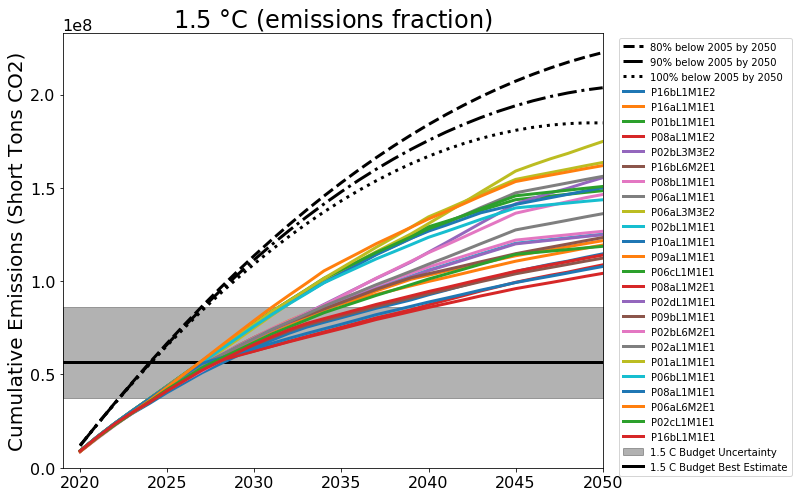

In [64]:
target = 1.5
fig, ax = cumulative_plot(carbon_budgets_tep_emissions_based[target], target, 'emissions')

emissions_by2050_plot(yearly_emissions_by2050_cumulative, (fig, ax))

ax.set_ylim(0, None)
ax.legend(**legend_kwargs)

fig.savefig(output_path / f'portfolios_{target}C_emissions_based_no_portfolios.png', dpi=300)

for name, cumulative in cumulatives.items():
    ax.plot(cumulative.index, cumulative.values, zorder=10, label=name)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:] + [handles[0]], labels[1:] + [labels[0]], **legend_kwargs)

fig.savefig(output_path / f'portfolios_{target}C_emissions_based.png', dpi=300)

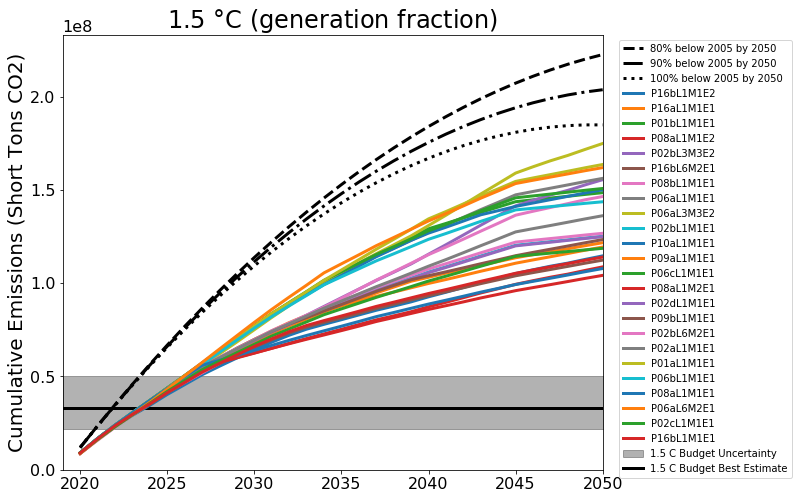

In [65]:
target = 1.5
fig, ax = cumulative_plot(carbon_budgets_tep_generation_based[target], target, 'generation')

emissions_by2050_plot(yearly_emissions_by2050_cumulative, (fig, ax))

ax.set_ylim(0, None)
ax.legend(**legend_kwargs)
fig.savefig(output_path / f'portfolios_{target}C_generation_based_no_portfolios.png', dpi=300)

for name, cumulative in cumulatives.items():
    ax.plot(cumulative.index, cumulative.values, zorder=10, label=name)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:] + [handles[0]], labels[1:] + [labels[0]], **legend_kwargs)

fig.savefig(output_path / f'portfolios_{target}C_generation_based.png', dpi=300)

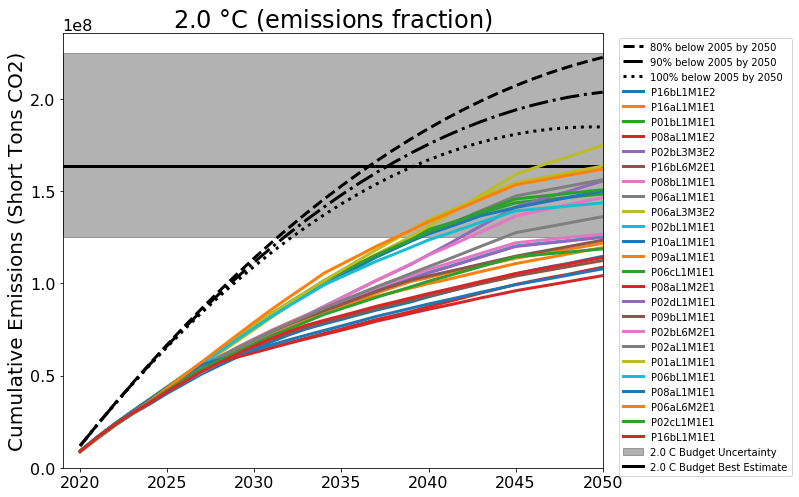

In [66]:
target = 2.0
fig, ax = cumulative_plot(carbon_budgets_tep_emissions_based[target], target, 'emissions')

emissions_by2050_plot(yearly_emissions_by2050_cumulative, (fig, ax))

ax.set_ylim(0, None)
ax.legend(**legend_kwargs)
fig.savefig(output_path / f'portfolios_{target}C_emissions_based_no_portfolios.png', dpi=300)

for name, cumulative in cumulatives.items():
    ax.plot(cumulative.index, cumulative.values, zorder=10, label=name)

ax.set_ylim(0, None)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:] + [handles[0]], labels[1:] + [labels[0]], **legend_kwargs)

fig.savefig(output_path / f'portfolios_{target}C_emissions_based.png', dpi=300)

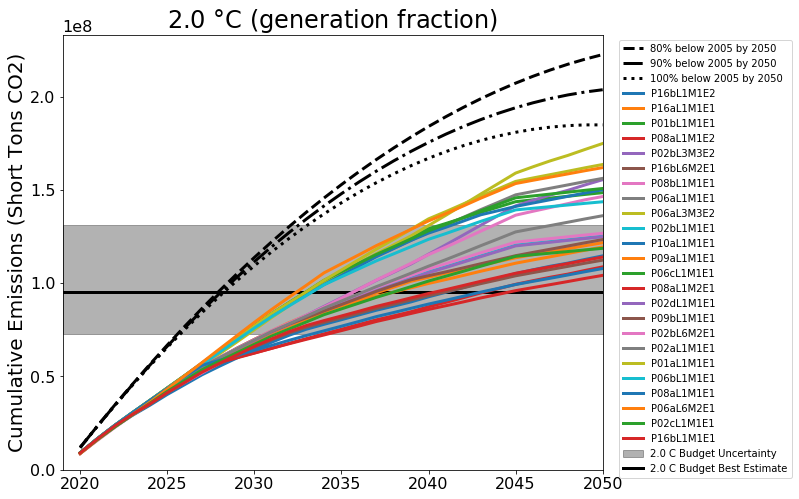

In [67]:
target = 2.0
fig, ax = cumulative_plot(carbon_budgets_tep_generation_based[target], target, 'generation')

emissions_by2050_plot(yearly_emissions_by2050_cumulative, (fig, ax))

ax.set_ylim(0, None)
ax.legend(**legend_kwargs)
fig.savefig(output_path / f'portfolios_{target}C_generation_based_no_portfolios.png', dpi=300)

for name, cumulative in cumulatives.items():
    ax.plot(cumulative.index, cumulative.values, zorder=10, label=name)

ax.set_ylim(0, None)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:] + [handles[0]], labels[1:] + [labels[0]], **legend_kwargs)

fig.savefig(output_path / f'portfolios_{target}C_generation_based.png', dpi=300)

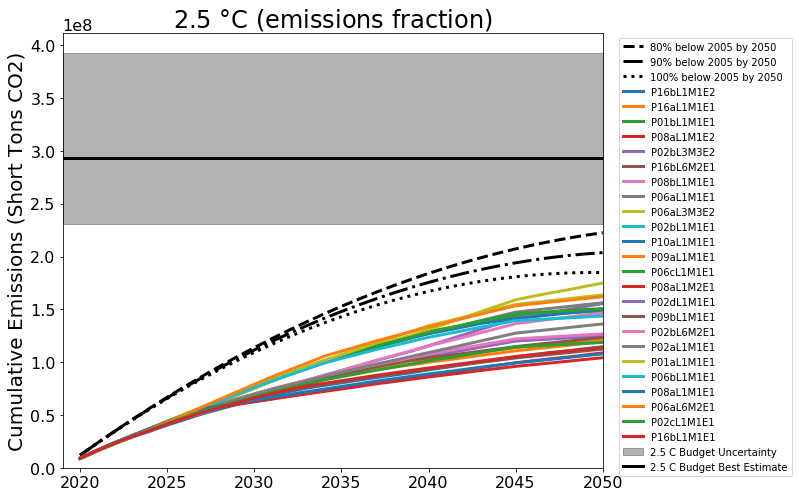

In [68]:
target = 2.5
fig, ax = cumulative_plot(carbon_budgets_tep_emissions_based[target], target, 'emissions')

emissions_by2050_plot(yearly_emissions_by2050_cumulative, (fig, ax))

ax.set_ylim(0, None)
ax.legend(**legend_kwargs)
fig.savefig(output_path / f'portfolios_{target}C_emissions_based_no_portfolios.png', dpi=300)

for name, cumulative in cumulatives.items():
    ax.plot(cumulative.index, cumulative.values, zorder=10, label=name)

ax.set_ylim(0, None)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:] + [handles[0]], labels[1:] + [labels[0]], **legend_kwargs)

fig.savefig(output_path / f'portfolios_{target}C_emissions_based.png', dpi=300)

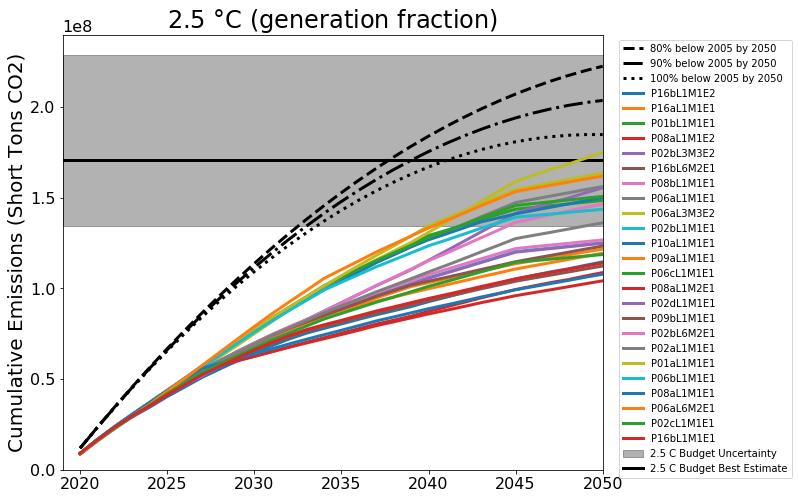

In [69]:
target = 2.5
fig, ax = cumulative_plot(carbon_budgets_tep_generation_based[target], target, 'generation')

emissions_by2050_plot(yearly_emissions_by2050_cumulative, (fig, ax))

ax.set_ylim(0, None)
ax.legend(**legend_kwargs)
fig.savefig(output_path / f'portfolios_{target}C_generation_based_no_portfolios.png', dpi=300)

for name, cumulative in cumulatives.items():
    ax.plot(cumulative.index, cumulative.values, zorder=10, label=name)

ax.set_ylim(0, None)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:] + [handles[0]], labels[1:] + [labels[0]], **legend_kwargs)

fig.savefig(output_path / f'portfolios_{target}C_generation_based.png', dpi=300)

In [70]:
def cumulative_plot_base(carbon_budgets_tep, kind):
    """
    Parameters
    ----------
    carbon_budget_tep : DataFrame
        
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.subplots_adjust(right=0.75)
    finite_cy_iter = iter(cycler(color=['skyblue', 'yellowgreen', 'orangered']))
    for target, budget in carbon_budgets_tep.items():
        styles = dict(next(finite_cy_iter))
        ax.axhline(budget['best'], label=f'{target} C Budget Best Estimate', **styles)
        ax.fill_between((cumulative.index[0] - 1, cumulative.index[-1] + 1), budget['low'], budget['high'], alpha=0.3, label=f'{target} C Budget Uncertainty', **styles)
        ax.set_xlim(cumulative.index[0] - 1, cumulative.index[-1])
    ax.set_ylabel('Cumulative TEP Emissions (Short Tons CO2)')
    ax.set_title(f'1.5, 2.0, 2.5 $\degree$C ({kind} fraction)')
    return fig, ax

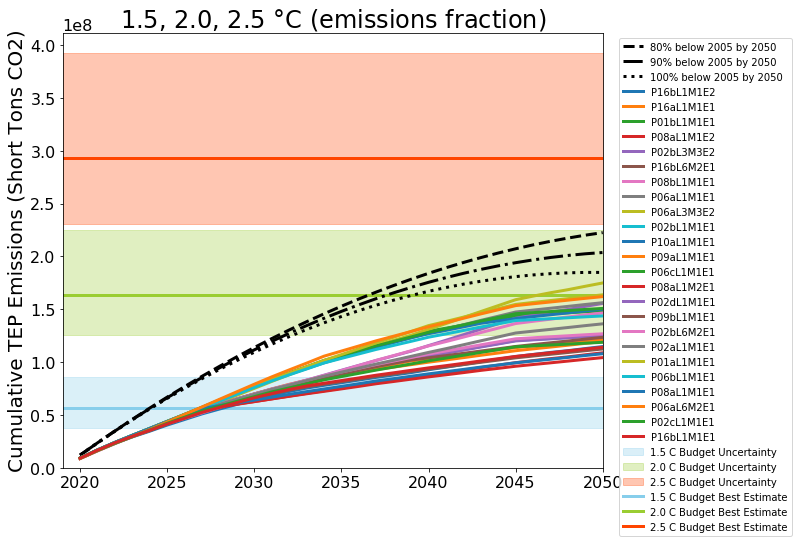

In [71]:
fig, ax = cumulative_plot_base(carbon_budgets_tep_emissions_based, 'emissions')

emissions_by2050_plot(yearly_emissions_by2050_cumulative, (fig, ax))

ax.set_ylim(0, None)
ax.legend(**legend_kwargs)
fig.savefig(output_path / f'portfolios_1.5_2.0_2.5_C_emissions_based_no_portfolios.png', dpi=300)

for name, cumulative in cumulatives.items():
    ax.plot(cumulative.index, cumulative.values, zorder=10, label=name)

ax.set_ylim(0, None)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[3:] + handles[0:3], labels[3:] + labels[0:3], **legend_kwargs)

fig.savefig(output_path / 'portfolios_1.5_2.0_2.5_C_emissions_based.png', dpi=300)

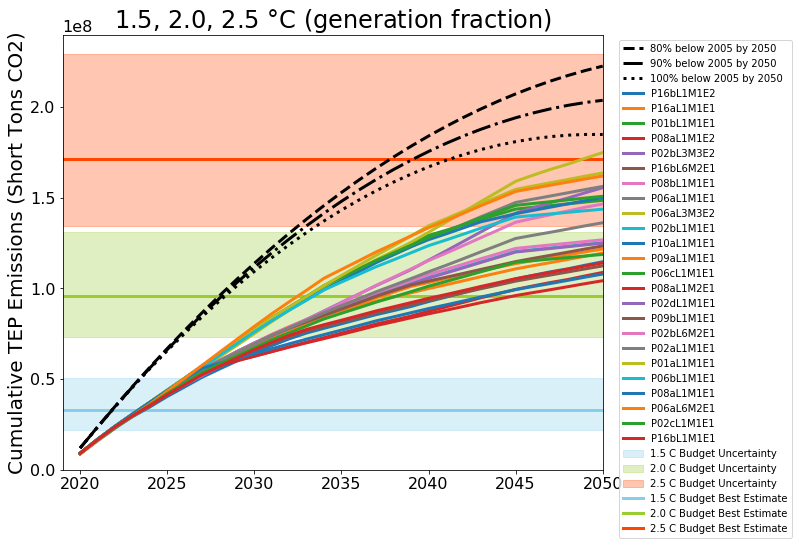

In [72]:
fig, ax = cumulative_plot_base(carbon_budgets_tep_generation_based, 'generation')

emissions_by2050_plot(yearly_emissions_by2050_cumulative, (fig, ax))

ax.set_ylim(0, None)
ax.legend(**legend_kwargs)
fig.savefig(output_path / f'portfolios_1.5_2.0_2.5_C_generation_based_no_portfolios.png', dpi=300)

for name, cumulative in cumulatives.items():
    ax.plot(cumulative.index, cumulative.values, zorder=10, label=name)

ax.set_ylim(0, None)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[3:] + handles[0:3], labels[3:] + labels[0:3], **legend_kwargs)

fig.savefig(output_path / 'portfolios_1.5_2.0_2.5_C_generation_based.png', dpi=300)

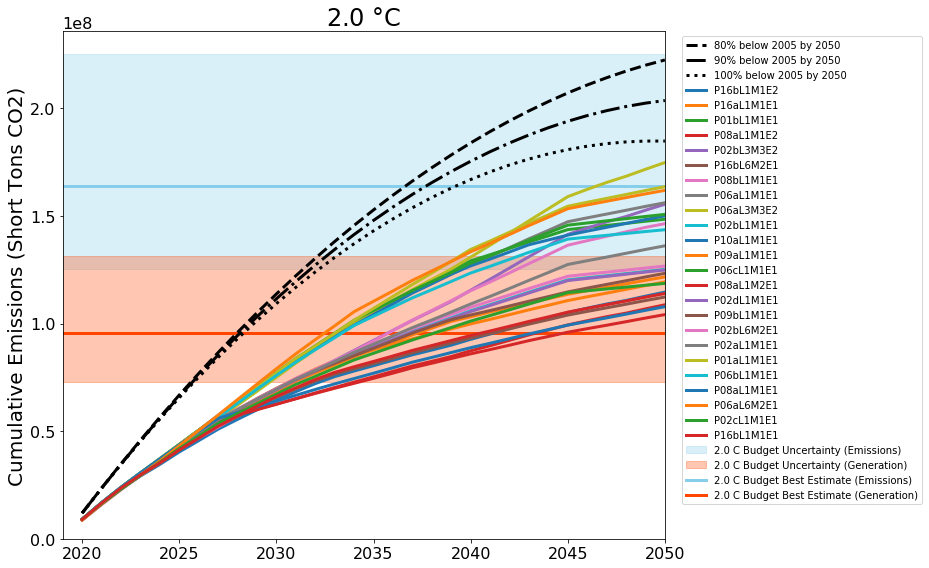

In [73]:
target = 2.0
fig, ax = plt.subplots(figsize=(13, 8))
fig.subplots_adjust(right=0.75)

color = 'skyblue'
carbon_budget_tep = carbon_budgets_tep_emissions_based[target]
ax.axhline(carbon_budget_tep['best'], label=f'{target} C Budget Best Estimate (Emissions)', color=color)
ax.fill_between((cumulative.index[0] - 1, cumulative.index[-1] + 1), carbon_budget_tep['low'], carbon_budget_tep['high'], color=color, alpha=0.3, label=f'{target} C Budget Uncertainty (Emissions)')

color = 'orangered'
carbon_budget_tep = carbon_budgets_tep_generation_based[target]
ax.axhline(carbon_budget_tep['best'], label=f'{target} C Budget Best Estimate (Generation)', color=color)
ax.fill_between((cumulative.index[0] - 1, cumulative.index[-1] + 1), carbon_budget_tep['low'], carbon_budget_tep['high'], color=color, alpha=0.3, label=f'{target} C Budget Uncertainty (Generation)')

ax.set_xlim(cumulative.index[0] - 1, cumulative.index[-1])
ax.set_ylabel('Cumulative Emissions (Short Tons CO2)')
ax.set_title(f'{target} $\degree$C')

emissions_by2050_plot(yearly_emissions_by2050_cumulative, (fig, ax))

ax.set_ylim(0, None)
ax.legend(**legend_kwargs)

plt.tight_layout()

fig.savefig(output_path / f'portfolios_{target}C_emissions_generation_based_no_portfolios.png', dpi=300)

for name, cumulative in cumulatives.items():
    ax.plot(cumulative.index, cumulative.values, zorder=10, label=name)

ax.set_ylim(0, None)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[2:] + handles[0:2], labels[2:] + labels[0:2], **legend_kwargs)

fig.savefig(output_path / f'portfolios_{target}C_emissions_generation_based.png', dpi=300)

## Yearly Graphs

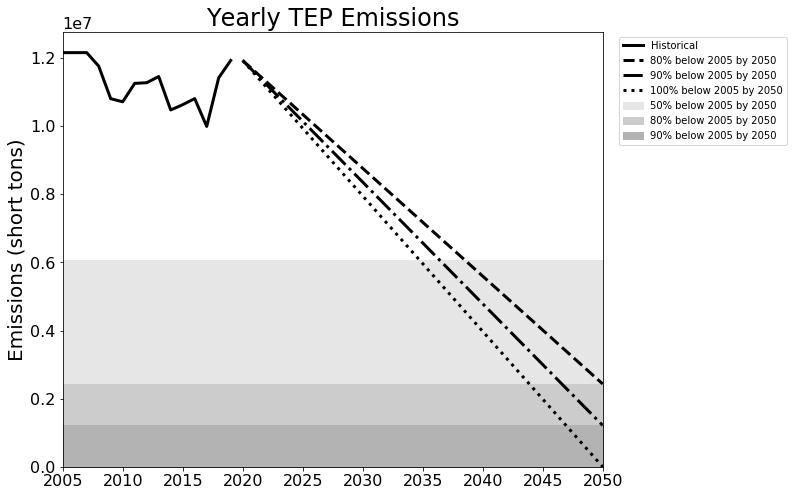

In [74]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.subplots_adjust(right=0.75)

historical_emissions = tep_emissions['TEP Direct (Scope 1) Emissions']
ax.plot(historical_emissions.index, historical_emissions.values, color='k', label='Historical')

emissions_by2050_plot(yearly_emissions_by2050, (fig, ax))

start = historical_emissions.index[0]
end = yearly_emissions_by2050.index[-1]
ax.fill_between((start, end), 0, 0.5 * tep_emissions_2005, color='0.9', label='50% below 2005 by 2050', zorder=1)
ax.fill_between((start, end), 0, 0.2 * tep_emissions_2005, color='0.8', label='80% below 2005 by 2050', zorder=1)
ax.fill_between((start, end), 0, 0.1 * tep_emissions_2005, color='0.7', label='90% below 2005 by 2050', zorder=1)

ax.set_xlim(start, end)
ax.set_ylim(0, None)
ax.set_ylabel('Emissions (short tons)')
ax.legend(**legend_kwargs)

ax.set_title(f'Yearly TEP Emissions')

fig.savefig(output_path / 'historical_and_projected_no_portfolios.png', dpi=300)

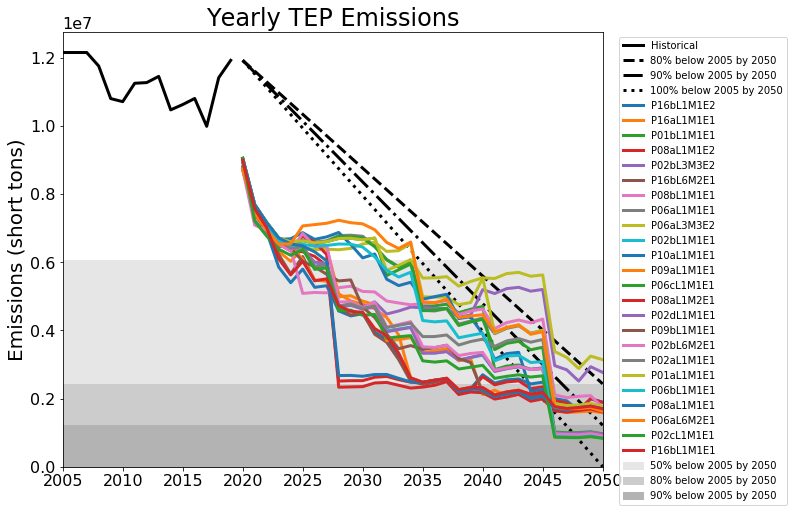

In [75]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.subplots_adjust(right=0.75)

historical_emissions = tep_emissions['TEP Direct (Scope 1) Emissions']
ax.plot(historical_emissions.index, historical_emissions.values, color='k', label='Historical')

emissions_by2050_plot(yearly_emissions_by2050, (fig, ax))

start = historical_emissions.index[0]
end = yearly_emissions_by2050.index[-1]
ax.fill_between((start, end), 0, 0.5 * tep_emissions_2005, color='0.9', label='50% below 2005 by 2050', zorder=1)
ax.fill_between((start, end), 0, 0.2 * tep_emissions_2005, color='0.8', label='80% below 2005 by 2050', zorder=1)
ax.fill_between((start, end), 0, 0.1 * tep_emissions_2005, color='0.7', label='90% below 2005 by 2050', zorder=1)

for name, yearly in yearlys.items():
    ax.plot(yearly.index, yearly.values, zorder=10, label=name)

ax.set_xlim(start, end)
ax.set_ylim(0, None)
ax.set_ylabel('Emissions (short tons)')
ax.legend(**legend_kwargs)

ax.set_title(f'Yearly TEP Emissions')

fig.savefig(output_path / 'historical_and_projected.png', dpi=300)

## Global Warming Implications for each Portfolio

In [76]:
def calc_global_warming_from_tep(
        cumulative_emissions, 
        tcre,
        us_frac=US_FRAC,  # assume budget based INDC estimates (PROVISIONAL)
        us_electric_frac=US_ELECTRIC_FRAC,
        tep_frac=TEP_FRAC,  # avg fraction of emissions 2005 - 2018
        historical_warming=HISTORICAL_WARMING,
        non_CO2_temperature_effect=NON_CO2_TEMPERATURE_EFFECT[1],
        zero_emissions_commitment_effect=0,
        earth_system_feedback=EARTH_SYSTEM_FEEDBACK,
        emissions_since_historical=EMISSIONS_SINCE_HISTORICAL
    ):
    """Calculate global warming consistent with TEP cumulative emissions
    Uncertainty is not explicitly accounted for, but may be 
    empirically determined by supplying array or Series inputs 
    for the parameters.
    
    Parameters
    ----------
    cumulative_emissions : array_like
        TEP cumulative emissions in short tons
    tcre : array_like
        Transient Response to Cumulative Carbon Emissions in degrees per metric ton
    us_frac : float
        Fraction of cumulative global emissions allocated to US
    us_electric_frac : float
        Fraction of cumulative US emissions allocated to US electric sector
    tep_frac : float
        Fraction of cumulative US electric emissions allocated to TEP
    historical_warming : float
        Degrees change over a preindustrial period. 
    non_CO2_temperature_effect : float
        Account for warming due to non-CO2 forcing such as
        sulfur dioxide. Default value is for 2 C or greater warming.
        Improve by making contingent on scenario, but how to do 
        that is not straightforward.
    zero_emissions_commitment_effect : float
        Account for nonlinearity or time lag of TCRE
    earth_system_feedback : float
        Account for feedback from changes such as melting 
        of permafrost.
    emissions_since_historical : float
        Additional emissions since the period defined by
        historical_warming.
        
    Returns
    -------
    carbon_budget_tep : array_like
        TEP carbon budget (same units as input global budget)
    """
    projected_warming_emissions_only = cumulative_emissions / metric_ton_to_short_ton / us_frac / us_electric_frac / tep_frac * tcre
    
    emissions_since_historical_warming = emissions_since_historical * tcre
    
    earth_system_feedback_warming = earth_system_feedback * tcre
    
    global_warming = (
        projected_warming_emissions_only + 
        non_CO2_temperature_effect + 
        historical_warming +
        zero_emissions_commitment_effect + 
        earth_system_feedback_warming +
        emissions_since_historical_warming
    )
    
    return global_warming

In [77]:
portfolio_degrees_c_emissions_based = calc_global_warming_from_tep(cumulatives.loc[2050], tcre_tons_co2_rogelj2019['best'], tep_frac=tep_emissions_fraction_mean)
portfolio_degrees_c_generation_based = calc_global_warming_from_tep(cumulatives.loc[2050], tcre_tons_co2_rogelj2019['best'], tep_frac=tep_generation_fraction_mean)

In [78]:
comment = f'# Global warming through 2050 consistent with each TEP portfolio. Based on historical TEP emissions fraction. Created {now} \n'
with open(output_path / 'warming_for_each_portfolio_emissions_based.csv', 'w') as f:
    f.write(comment)
    portfolio_degrees_c_emissions_based.to_csv(f, index_label='portfolio')
    
comment = f'# Global warming through 2050 consistent with each TEP portfolio. Based on historical TEP generation fraction. Created {now} \n'
with open(output_path / 'warming_for_each_portfolio_generation_based.csv', 'w') as f:
    f.write(comment)
    portfolio_degrees_c_generation_based.to_csv(f, index_label='portfolio')

In [79]:
def autolabel(pnts):
    """Attach a text label above each point in *pnts*"""
    for pnt, label in pnts:
        ax.annotate(label,
                    xy=(pnt, 0),
                    xytext=(0, 4),
                    textcoords="offset points",
                    ha='left', va='bottom', rotation=45)

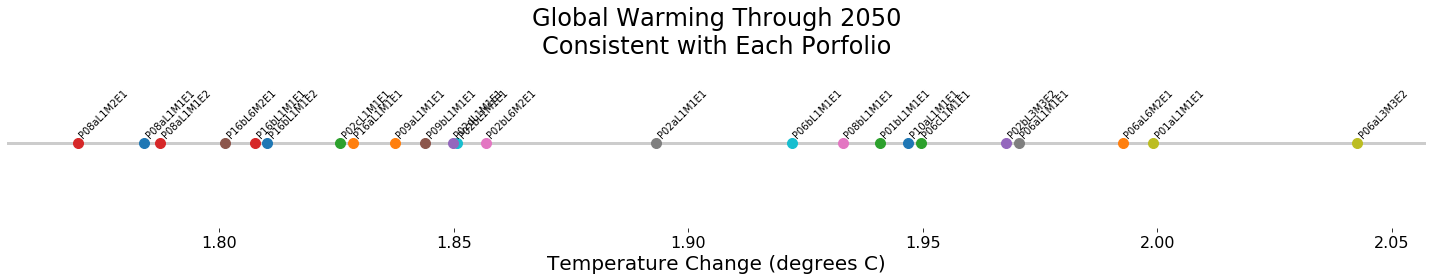

In [80]:
fig, ax = plt.subplots(figsize=(20, 4))
# fig.subplots_adjust(bottom=0.1, top=0.2)
ax.axhline(0, color='k', alpha=0.2, zorder=-1)
pnts = []
for label, value in portfolio_degrees_c_emissions_based.items():
    pnt = ax.scatter(value, 0, label=label)
    pnts.append((value, label))
ax.set_xlabel(f'Temperature Change (degrees C)')
ax.set_title(f'Global Warming Through 2050\nConsistent with Each Porfolio')
ax.yaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

autolabel(pnts)

plt.tight_layout()

fig.savefig(output_path / 'warming_for_each_portfolio_emissions_based.png', dpi=300)

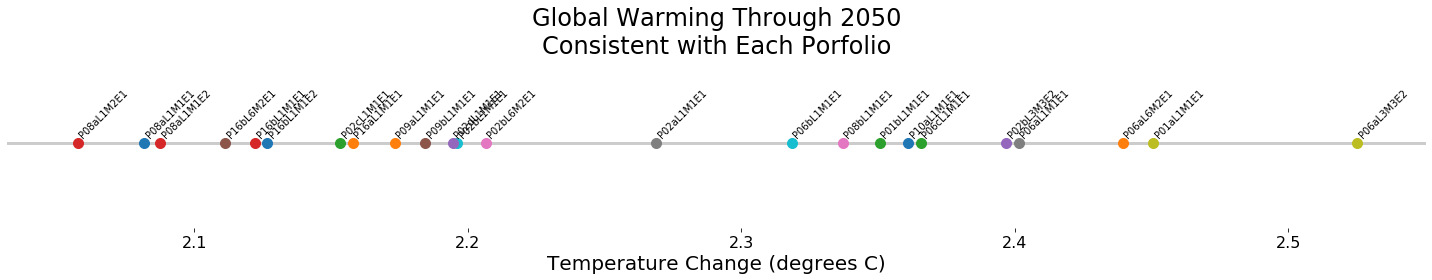

In [81]:
fig, ax = plt.subplots(figsize=(20, 4))
# fig.subplots_adjust(right=0.75, bottom=0.7)
ax.axhline(0, color='k', alpha=0.2, zorder=-1)
pnts = []
for label, value in portfolio_degrees_c_generation_based.items():
    ax.scatter(value, 0, label=label)
    pnts.append((value, label))
ax.set_xlabel(f'Temperature Change (degrees C)')
ax.set_title(f'Global Warming Through 2050\nConsistent with Each Porfolio')
ax.yaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

autolabel(pnts)

plt.tight_layout()

fig.savefig(output_path / 'warming_for_each_portfolio_generation_based.png', dpi=300)

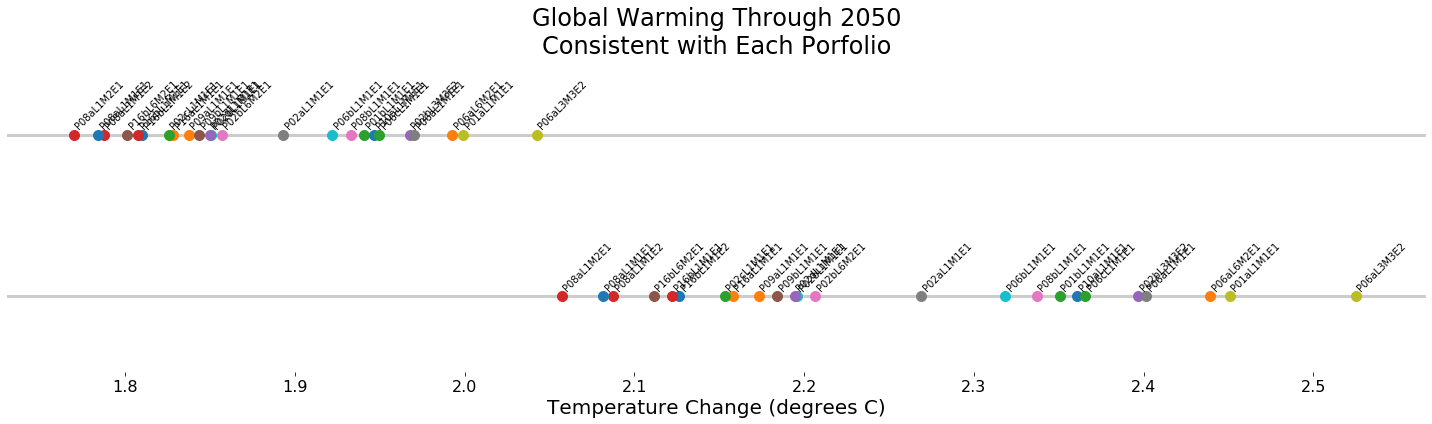

In [82]:
fig, axes = plt.subplots(2, 1, figsize=(20, 6), sharex=True)

ax = axes[0]
ax.axhline(0, color='k', alpha=0.2, zorder=-1)
pnts = []
for label, value in portfolio_degrees_c_emissions_based.items():
    ax.scatter(value, 0, label=label)
    pnts.append((value, label))
ax.set_title(f'Global Warming Through 2050\nConsistent with Each Porfolio')
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

autolabel(pnts)

ax = axes[1]
ax.axhline(0, color='k', alpha=0.2, zorder=-1)
pnts = []
for label, value in portfolio_degrees_c_generation_based.items():
    ax.scatter(value, 0, label=label)
    pnts.append((value, label))
ax.set_xlabel(f'Temperature Change (degrees C)')
ax.yaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

autolabel(pnts)


plt.tight_layout()

fig.savefig(output_path / 'warming_for_each_portfolio_emissions_and_generation_based.png', dpi=300)

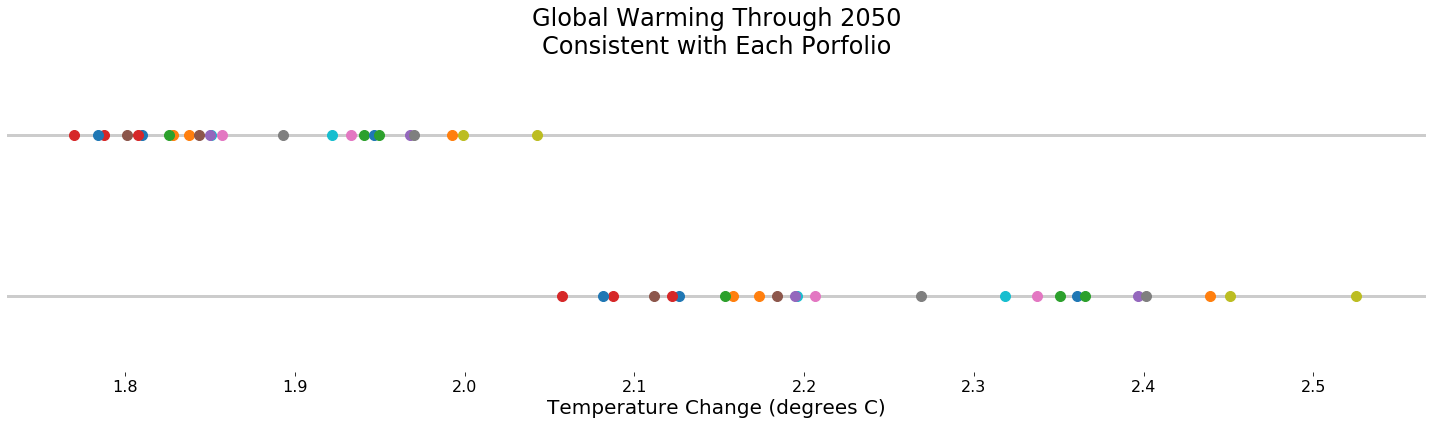

In [83]:
fig, axes = plt.subplots(2, 1, figsize=(20, 6), sharex=True)

ax = axes[0]
ax.axhline(0, color='k', alpha=0.2, zorder=-1)
pnts = []
for label, value in portfolio_degrees_c_emissions_based.items():
    ax.scatter(value, 0, label=label)
    pnts.append((value, label))
ax.set_title(f'Global Warming Through 2050\nConsistent with Each Porfolio')
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# autolabel(pnts)

ax = axes[1]
ax.axhline(0, color='k', alpha=0.2, zorder=-1)
pnts = []
for label, value in portfolio_degrees_c_generation_based.items():
    ax.scatter(value, 0, label=label)
    pnts.append((value, label))
ax.set_xlabel(f'Temperature Change (degrees C)')
ax.yaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# autolabel(pnts)


plt.tight_layout()

fig.savefig(output_path / 'warming_for_each_portfolio_emissions_and_generation_based_no_label.png', dpi=300)

# Other data

## State by state data

In [84]:
# https://www.eia.gov/beta/states/states/az/rankings
# site also has energy consumption per capita, production, electric gen
us_state_carbon_path = data_path / 'us_state_carbon_emissions_2017.csv'
us_state_carbon = pd.read_csv(
    us_state_carbon_path,
    skiprows=4,
    index_col=0
)
# units of million metric tons of CO2
us_state_carbon

,Ranking,Value
State,,
TX,1,707.0
CA,2,359.0
FL,3,227.0
LA,4,226.0
PA,5,215.0
OH,6,204.0
IL,7,201.0
IN,8,176.0
NY,9,157.0


In [85]:
# https://www.eia.gov/beta/states/states/az/data/dashboard/total-energy

In [86]:
# https://www.eia.gov/beta/states/states/az/data/dashboard/electricity